<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Untitled214.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================================
# GQR k(d) slices with provenance stamping + NPZ save/load
# ============================================================
import os, json, time, hashlib, platform, sys
import numpy as np
import matplotlib.pyplot as plt

# ---------- Output & config ----------
OUTDIR = "GQR_kdE_SLICES_PROVENANCE"
PROVDIR = os.path.join(OUTDIR, "PROVENANCE")
os.makedirs(OUTDIR, exist_ok=True)
os.makedirs(PROVDIR, exist_ok=True)

# Resonance comb controls
RESONANCE  = True
COMB_AMP   = 2.0     # try 1,2,3,5 as needed
COMB_WIDTH = 0.25    # 0.10–0.35 typical

# Distance & energy slices
d = np.linspace(0.1, 3.0, 600)              # Å
E_slices = [0.0, 0.2, 0.6, 1.2, 1.8]        # eV

# Y-scale windows (same as your previous “wide zoom”)
Y_E = (5e10, 5e12)   # electrons
Y_H = (5e3,  5e5)    # protons

# Baseline QM (your fits)
R0_e, beta_e = 1.68e11, 0.64
R0_H, beta_H = 9.42e3,  0.77
def k_qm(R0, beta, d):
    return R0 * np.exp(-beta*d)
kQM_e = k_qm(R0_e, beta_e, d)
kQM_H = k_qm(R0_H, beta_H, d)

# ---------- Provenance helpers ----------
def _sha256(path):
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(1<<20), b''):
            h.update(chunk)
    return h.hexdigest()

def save_run_npz(path, arrays: dict, params: dict):
    np.savez_compressed(path, **arrays)
    meta = {
        "params": params,
        "created_utc": time.strftime("%Y-%m-%dT%H:%M:%SZ", time.gmtime()),
        "python": sys.version.split()[0],
        "numpy": np.__version__,
        "platform": platform.platform(),
    }
    with open(path + ".json", "w") as f:
        json.dump(meta, f, indent=2)
    return _sha256(path)

def load_run_npz(path):
    data = np.load(path)
    arrays = {k: data[k] for k in data.files}
    meta = {}
    try:
        with open(path + ".json") as f:
            meta = json.load(f)
    except FileNotFoundError:
        pass
    return arrays, meta, _sha256(path)

def compare_runs(saved_arrays: dict, live_arrays: dict, rtol=1e-8, atol=1e-12):
    out = {}
    for k in saved_arrays:
        if k in live_arrays:
            a, b = saved_arrays[k], live_arrays[k]
            same = (a.shape == b.shape) and np.allclose(a, b, rtol=rtol, atol=atol)
            out[k] = bool(same)
        else:
            out[k] = None
    return out

def annotate_plot(ax, title, params: dict, hash_short=None):
    keys = ["RESONANCE", "COMB_AMP", "COMB_WIDTH", "E_slice", "hydrated",
            "beta_e", "beta_H", "R0_e", "R0_H"]
    lines = [title] + [f"{k}={params[k]}" for k in keys if k in params]
    if hash_short:
        lines.append(f"npz={hash_short[:10]}…")
    ax.text(0.01, 0.99, "\n".join(lines),
            transform=ax.transAxes, va="top", ha="left",
            bbox=dict(facecolor="white", alpha=0.85, edgecolor="0.6"),
            fontsize=8)

# ---------- GQR helpers ----------
def sigmoid(x, x0, k):
    return 1.0/(1.0+np.exp(-k*(x-x0)))

def shield_loss(d, alpha, d0, p):
    S = 1.0 - alpha*np.exp(-(d/d0)**p)
    return np.clip(S, 1e-6, 1.0)

def lorentzian(x, x0, gamma):
    return gamma**2/((x-x0)**2 + gamma**2)

def resonance_comb(d, amp, width, taper_len=3.0):
    if amp <= 0:
        return np.ones_like(d)
    centers = np.array([0.7, 1.0, 1.5, 2.2])
    # normalized sum of Lorentzians
    num = np.sum(width**2 / ((d[None,:]-centers[:,None])**2 + width**2), axis=0)
    num /= (np.max(num) + 1e-12)
    return 1.0 + amp * num * np.exp(-d/taper_len)

def gqr_curve(kQM, beta, E_val, species, hydrated):
    # species-specific caps (kept modest & symmetric so e/H share same logic)
    if species=='e':
        E0, ksig = 0.30, 4.0
        eta_max  = 0.32 if hydrated else 0.28
        duty_max = 1.90 if hydrated else 1.50
        alpha_sh = 0.08 if hydrated else 0.14
    else:
        E0, ksig = 0.45, 3.5
        eta_max  = 0.38 if hydrated else 0.34
        duty_max = 2.10 if hydrated else 1.60
        alpha_sh = 0.06 if hydrated else 0.12

    etaH = eta_max * sigmoid(E_val, E0, ksig) if E_val>0 else 0.0
    Duty = 1.0 + (duty_max-1.0)*sigmoid(E_val, E0, ksig) if E_val>0 else 1.0

    beta_eff = max(beta*(1.0-etaH), 0.20)
    boost = np.exp((beta - beta_eff)*d)
    loss  = shield_loss(d, alpha=alpha_sh, d0=0.8, p=2.0)
    comb  = resonance_comb(d, COMB_AMP, COMB_WIDTH) if RESONANCE else 1.0
    return kQM * boost * Duty * comb * loss

def first_crossing(d, k_gqr, k_qm):
    r = k_gqr / k_qm
    if np.all(r < 1.0):
        return (None, None)
    idx = np.argmax(r >= 1.0)
    return (d[idx], r[idx])

# ---------- Plot grid with provenance ----------
COL_E, COL_H = 'darkorange', 'royalblue'
LW = 2.2

print("— Shield-cross distances where GQR ≥ QM (wide zoom) —")
fig, axes = plt.subplots(len(E_slices), 2, figsize=(12.3, 14.5), sharex=True)

for row, Eval in enumerate(E_slices):
    # ----- Electron panel -----
    k_dry_e  = gqr_curve(kQM_e, beta_e, Eval, 'e', hydrated=False)
    k_wet_e  = gqr_curve(kQM_e, beta_e, Eval, 'e', hydrated=True)
    ax = axes[row, 0]
    ax.set_yscale('log'); ax.set_ylim(*Y_E)
    ax.plot(d, kQM_e,  color=COL_E, alpha=0.30, lw=1.6, label="QM")
    ax.plot(d, k_dry_e, color=COL_E, lw=LW,  ls='-',  label="GQR dry")
    ax.plot(d, k_wet_e, color=COL_E, lw=LW,  ls='--', label="GQR hydrated")
    ax.set_title(f"Electron — E = {Eval:.1f} eV")
    ax.grid(True, which='both', alpha=0.25)
    if Eval > 0.0:
        dx, _ = first_crossing(d, k_dry_e, kQM_e)
        wx, _ = first_crossing(d, k_wet_e, kQM_e)
        if dx is not None: ax.axvline(dx, color=COL_E, lw=1.1, ls=':', alpha=0.8)
        if wx is not None: ax.axvline(wx, color=COL_E, lw=1.1, ls='--', alpha=0.5)

    # save NPZ + annotate
    arrays_e = {"d": d, "kQM": kQM_e, "k_dry": k_dry_e, "k_wet": k_wet_e}
    params_e = {
        "species": "e", "E_slice": float(Eval), "hydrated": True,
        "RESONANCE": bool(RESONANCE),
        "COMB_AMP": float(COMB_AMP), "COMB_WIDTH": float(COMB_WIDTH),
        "beta_e": float(beta_e), "beta_H": float(beta_H),
        "R0_e": float(R0_e), "R0_H": float(R0_H)
    }
    npz_e = os.path.join(PROVDIR, f"k_vs_d_e_E{Eval:.1f}.npz")
    h_e = save_run_npz(npz_e, arrays_e, params_e)
    annotate_plot(ax, "Electron panel", params_e, h_e)

    if row == 0:
        ax.legend(loc="lower right", fontsize=8, frameon=True)

    # ----- Proton panel -----
    k_dry_H = gqr_curve(kQM_H, beta_H, Eval, 'H', hydrated=False)
    k_wet_H = gqr_curve(kQM_H, beta_H, Eval, 'H', hydrated=True)
    ax = axes[row, 1]
    ax.set_yscale('log'); ax.set_ylim(*Y_H)
    ax.plot(d, kQM_H,  color=COL_H, alpha=0.30, lw=1.6, label="QM")
    ax.plot(d, k_dry_H, color=COL_H, lw=LW,  ls='-',  label="GQR dry")
    ax.plot(d, k_wet_H, color=COL_H, lw=LW,  ls='--', label="GQR hydrated")
    ax.set_title(f"Proton — E = {Eval:.1f} eV")
    ax.grid(True, which='both', alpha=0.25)
    if Eval > 0.0:
        dx, _ = first_crossing(d, k_dry_H, kQM_H)
        wx, _ = first_crossing(d, k_wet_H, kQM_H)
        if dx is not None: ax.axvline(dx, color=COL_H, lw=1.1, ls=':', alpha=0.8)
        if wx is not None: ax.axvline(wx, color=COL_H, lw=1.1, ls='--', alpha=0.5)

    arrays_H = {"d": d, "kQM": kQM_H, "k_dry": k_dry_H, "k_wet": k_wet_H}
    params_H = dict(params_e); params_H.update({"species":"H"})
    npz_h = os.path.join(PROVDIR, f"k_vs_d_H_E{Eval:.1f}.npz")
    h_h = save_run_npz(npz_h, arrays_H, params_H)
    annotate_plot(ax, "Proton panel", params_H, h_h)

    if row == 0:
        ax.legend(loc="lower right", fontsize=8, frameon=True)

# shared labels
for ax in axes[:, 0]:
    ax.set_ylabel("Rate k (s⁻¹) [log]")
for ax in axes[-1, :]:
    ax.set_xlabel("Distance d (Å)")

plt.tight_layout()
fname = f"Fig_k_vs_d_slices_RES{'ON' if RESONANCE else 'OFF'}_A{COMB_AMP}_W{COMB_WIDTH}.png"
plt.savefig(os.path.join(OUTDIR, fname), dpi=300)
plt.show()
print("✅ Saved:", os.path.join(OUTDIR, fname))

# ---------- Provenance parity check (example) ----------
check_target = os.path.join(PROVDIR, "k_vs_d_e_E1.2.npz")
if os.path.exists(check_target):
    saved_arrays, meta, h2 = load_run_npz(check_target)
    live_arrays = {"d": d, "kQM": kQM_e,
                   "k_dry": gqr_curve(kQM_e, beta_e, 1.2, 'e', hydrated=False),
                   "k_wet": gqr_curve(kQM_e, beta_e, 1.2, 'e', hydrated=True)}
    checks = compare_runs(saved_arrays, live_arrays)
    print("Provenance check:", check_target, "| hash:", h2)
    print("Array parity:", checks)

# ---------- Snapshot sheet: GQR/QM ratios (dry vs wet) ----------
fig2, axes2 = plt.subplots(1, 2, figsize=(11.5, 4.6), sharex=True)
for species, ax in zip(("e","H"), axes2):
    kQM  = kQM_e if species=="e" else kQM_H
    beta = beta_e if species=="e" else beta_H
    col  = COL_E   if species=="e" else COL_H
    for Eval in E_slices:
        kd = gqr_curve(kQM, beta, Eval, species, hydrated=False)
        kw = gqr_curve(kQM, beta, Eval, species, hydrated=True)
        ax.plot(d, kd/kQM, lw=1.8, color=col, alpha=0.8, label=f"{Eval:.1f} eV dry")
        ax.plot(d, kw/kQM, lw=1.8, color=col, ls='--', alpha=0.8, label=f"{Eval:.1f} eV wet")
    ax.set_title(("Electron" if species=="e" else "Proton") + " — GQR/QM ratio")
    ax.set_xlabel("Distance d (Å)")
    ax.set_ylabel("GQR / QM (ratio)")
    ax.grid(True, alpha=0.25)
    # show a lean legend (first row only) to avoid spam:
    handles, labels = ax.get_legend_handles_labels()
    keep = []
    seen = set()
    for h,l in zip(handles, labels):
        tag = l.split()[0] + ("dry" if "dry" in l else "wet")
        if tag not in seen:
            keep.append((h,l))
            seen.add(tag)
    ax.legend(*zip(*keep), fontsize=8, ncol=2, frameon=True, loc="upper left")

plt.tight_layout()
snap_name = f"Fig_ratio_snapshots_RES{'ON' if RESONANCE else 'OFF'}_A{COMB_AMP}_W{COMB_WIDTH}.png"
plt.savefig(os.path.join(OUTDIR, snap_name), dpi=300)
plt.show()
print("✅ Saved:", os.path.join(OUTDIR, snap_name))

/tmp/ipython-input-1269028617.py:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("viridis", len(E_slices))


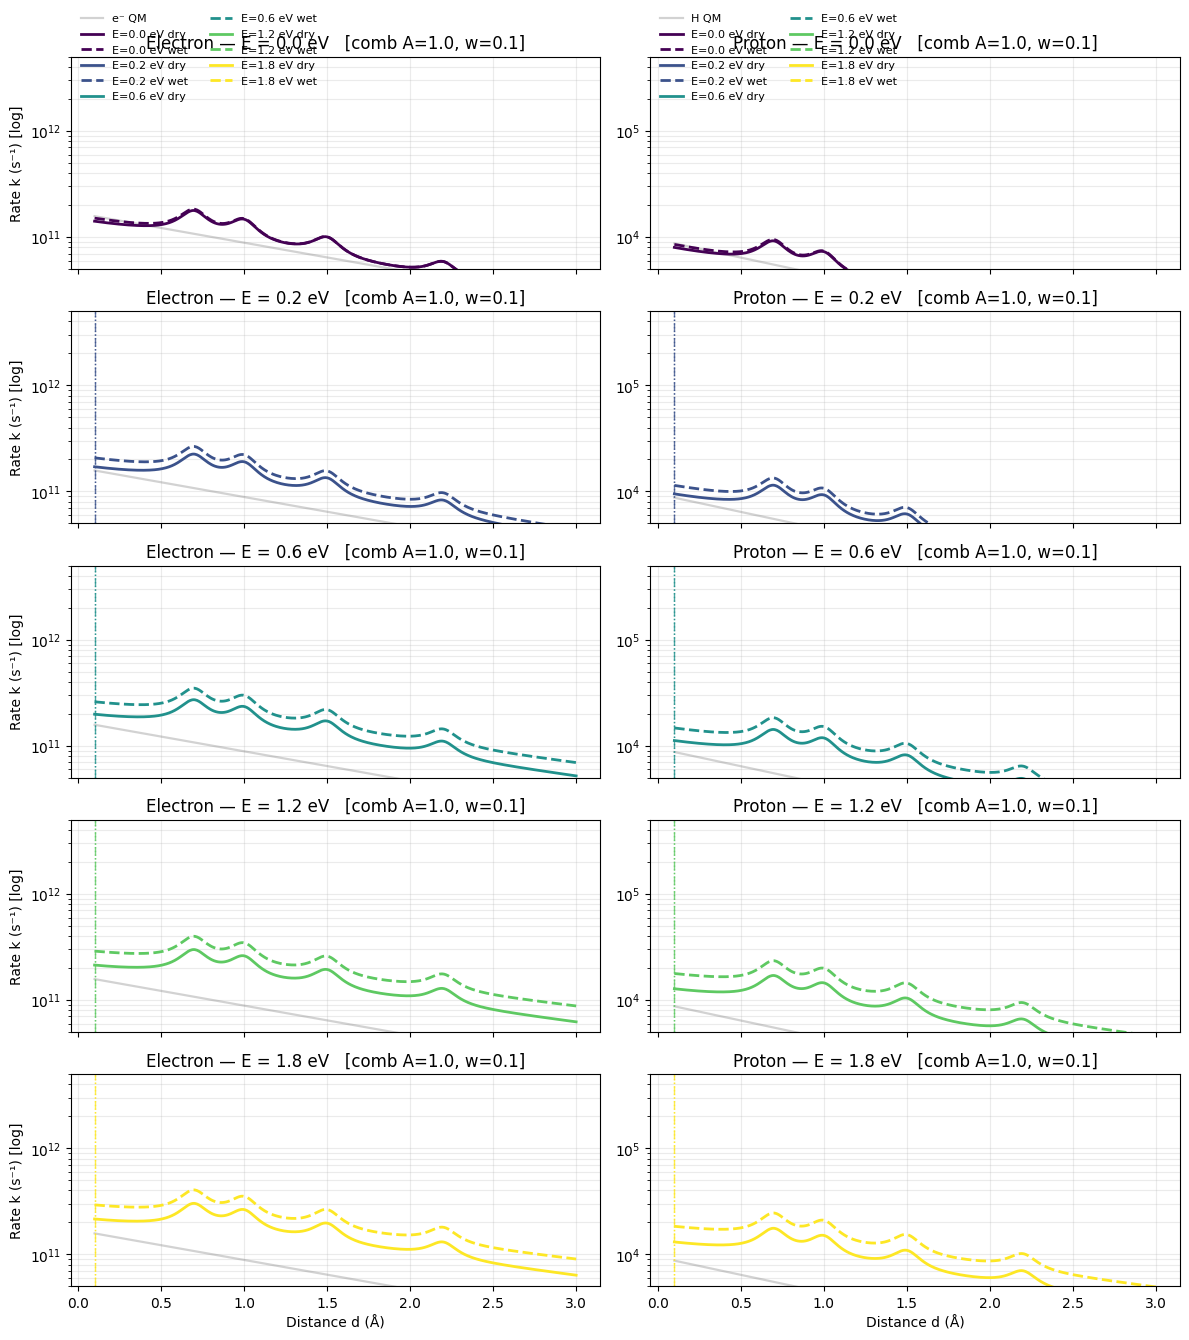

✅ Saved: GQR_kdE_SLICES_COLORED/Fig_k_vs_d_slices_COLORED_WITH_resonance.png


/tmp/ipython-input-1269028617.py:225: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  norm = np.sqrt(np.trapz(np.abs(psi)**2, x))


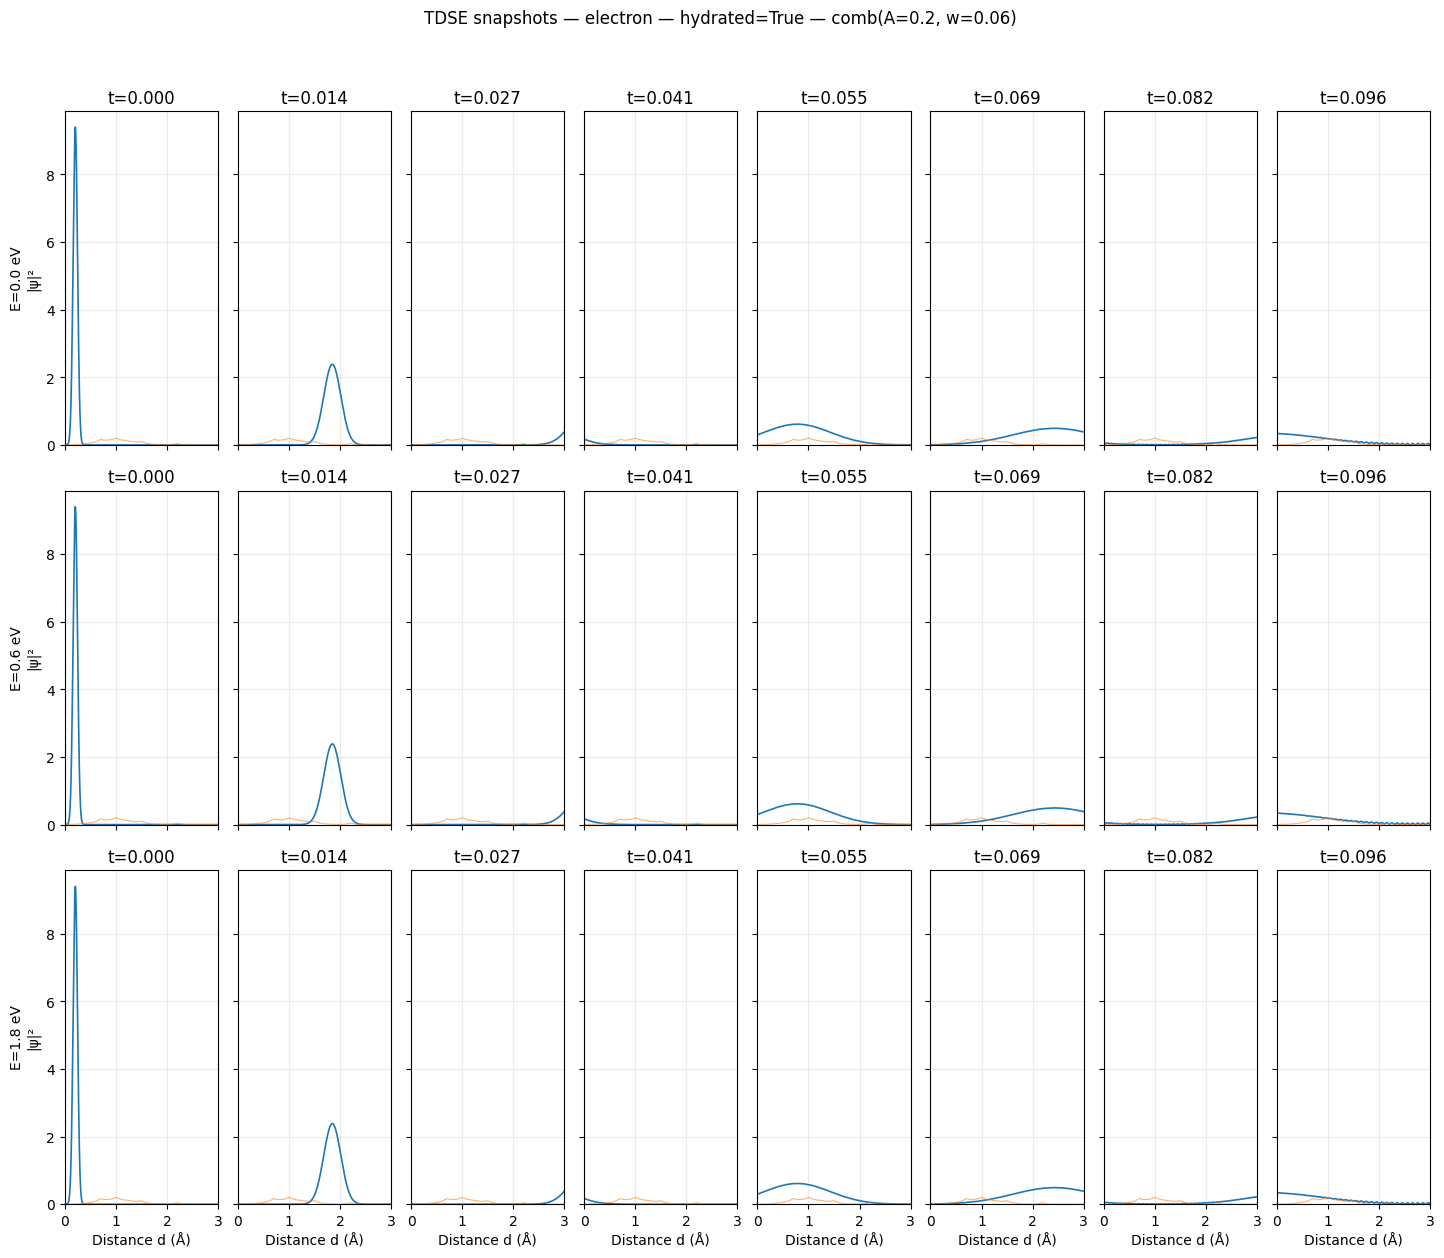

✅ saved TDSE_SNAPSHOTS_COLORED/TDSE_snapshots_electron.png


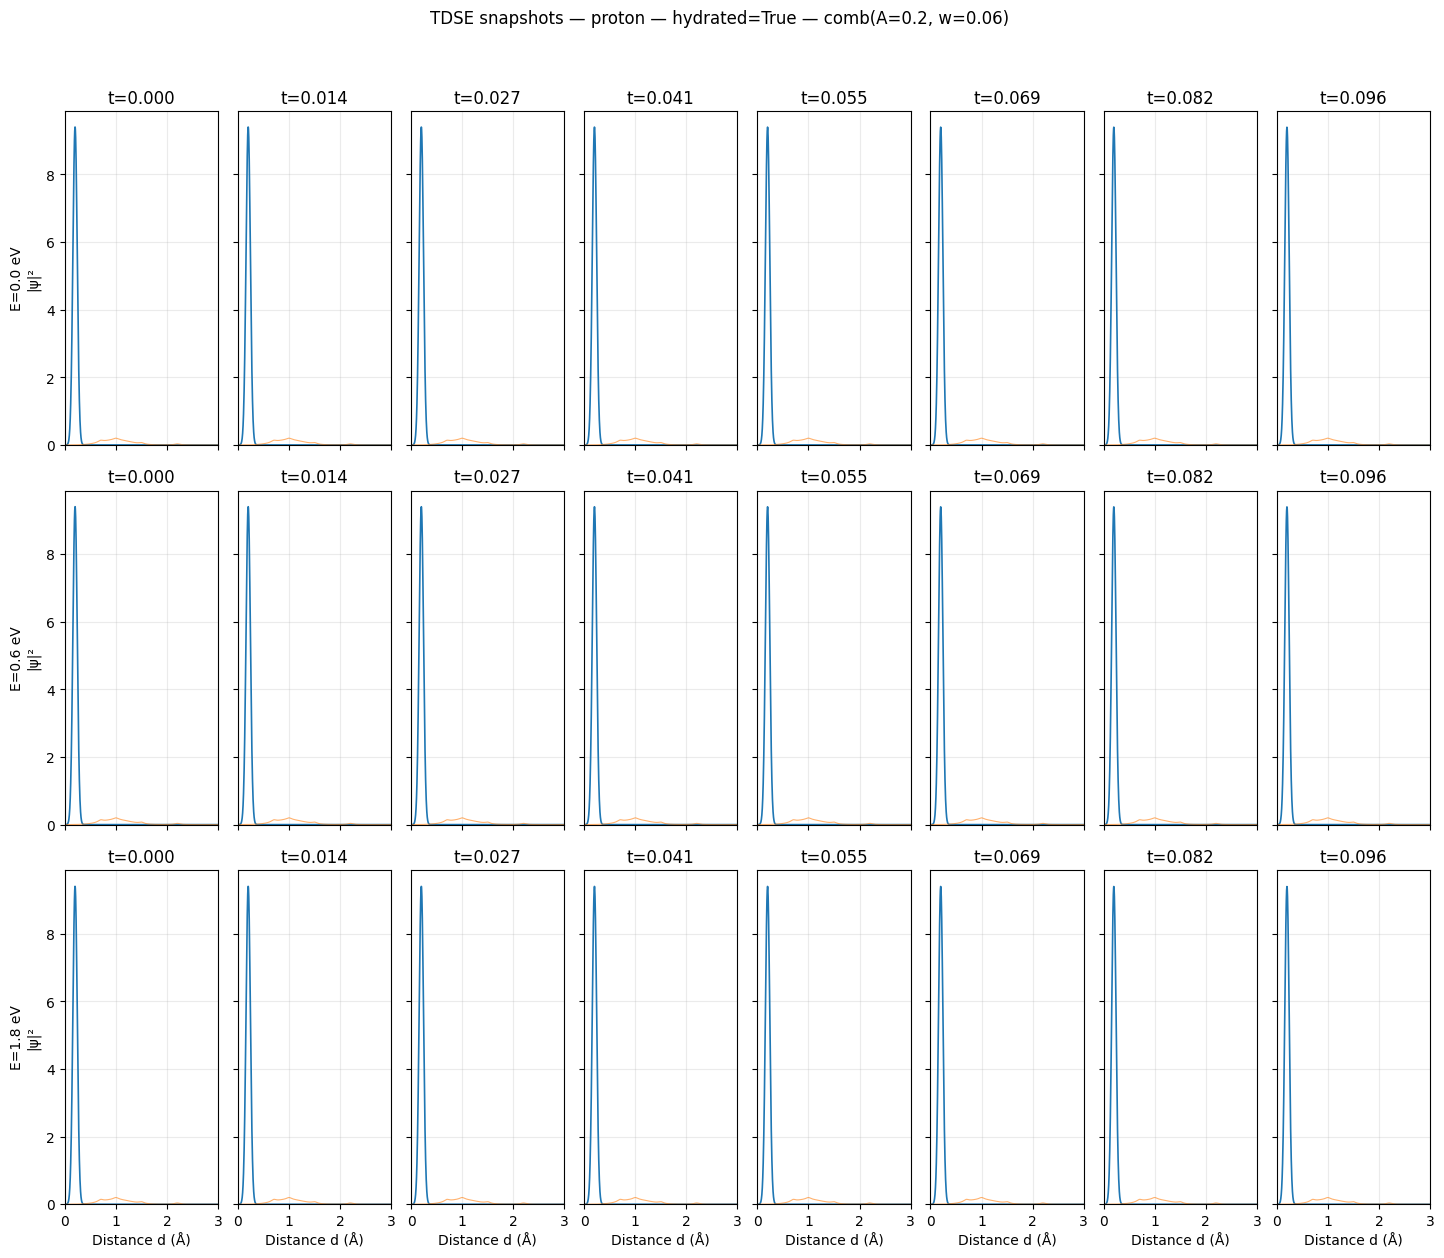

✅ saved TDSE_SNAPSHOTS_COLORED/TDSE_snapshots_proton.png


In [ ]:
# ============================================================
# PART A — k(d) slices with DISTINCT COLORS + tidy legends
# (pure NumPy + Matplotlib; no file I/O required)
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.lines import Line2D

OUTDIR = "GQR_kdE_SLICES_COLORED"
os.makedirs(OUTDIR, exist_ok=True)

# ---------- Toggle resonance ripples ----------
RESONANCE   = True
COMB_AMP    = 1.0     # annotate on-plot
COMB_WIDTH  = 0.10    # annotate on-plot

# ---------- Domains ----------
d = np.linspace(0.1, 3.0, 500)              # Å
E_slices = [0.0, 0.2, 0.6, 1.2, 1.8]        # eV

# ---------- y-scales ----------
Y_E = (5e10, 5e12)   # electron (log)
Y_H = (5e3,  5e5)    # proton   (log)

# ---------- Baseline QM ----------
R0_e, beta_e = 1.68e11, 0.64
R0_H, beta_H = 9.42e3,  0.77
def k_qm(R0, beta, d):
    return R0 * np.exp(-beta * d)
kQM_e = k_qm(R0_e, beta_e, d)
kQM_H = k_qm(R0_H, beta_H, d)

# ---------- Helpers ----------
def sigmoid(x, x0, k):
    return 1.0/(1.0+np.exp(-k*(x-x0)))

def shield_loss(d, alpha, d0, p):
    S = 1.0 - alpha*np.exp(-(d/d0)**p)
    return np.clip(S, 1e-6, 1.0)

def lorentzian(x, x0, gamma):
    return gamma**2/((x-x0)**2 + gamma**2)

def resonance_comb(d, amp, width, taper_len=3.0):
    centers = [0.7, 1.0, 1.5, 2.2]
    s = np.zeros_like(d, float)
    for c in centers:
        s += lorentzian(d, c, width)
    s /= (s.max()+1e-12)
    return 1.0 + amp*s*np.exp(-d/taper_len)

def gqr_curve(kQM, beta, E_val, species, hydrated):
    if species=='e':
        E0, ksig = 0.30, 4.0
        eta_max  = 0.28 if not hydrated else 0.34
        duty_max = 1.50 if not hydrated else 1.90
        alpha_sh = 0.14 if not hydrated else 0.08
    else:
        E0, ksig = 0.45, 3.5
        eta_max  = 0.34 if not hydrated else 0.40
        duty_max = 1.60 if not hydrated else 2.10
        alpha_sh = 0.12 if not hydrated else 0.06

    if E_val > 0:
        etaH = eta_max * sigmoid(E_val, E0, ksig)
        Duty = 1.0 + (duty_max-1.0)*sigmoid(E_val, E0, ksig)
    else:
        etaH, Duty = 0.0, 1.0

    beta_eff = max(beta*(1.0-etaH), 0.20)
    boost = np.exp((beta - beta_eff)*d)
    loss  = shield_loss(d, alpha=alpha_sh, d0=0.8, p=2.0)
    comb  = resonance_comb(d, COMB_AMP, COMB_WIDTH) if RESONANCE else 1.0

    return kQM * boost * Duty * comb * loss

def first_crossing(d, k_gqr, k_qm):
    r = k_gqr / k_qm
    idx = np.argmax(r >= 1.0)
    return (d[idx], r[idx]) if r[idx] >= 1.0 else (None, None)

# ---------- nice distinct colors for energies ----------
import matplotlib as mpl
cmap = mpl.cm.get_cmap("viridis", len(E_slices))
E_colors = {E: cmap(i) for i, E in enumerate(E_slices)}

def legend_for_species(species_label):
    # Custom legend: QM baseline (faded), Dry (solid), Wet (dashed) entries per E
    handles = [Line2D([0],[0], color='gray', lw=1.6, alpha=0.35, label=f"{species_label} QM")]
    for E in E_slices:
        col = E_colors[E]
        handles.append(Line2D([0],[0], color=col, lw=2.0, ls='-',  label=f"E={E:.1f} eV dry"))
        handles.append(Line2D([0],[0], color=col, lw=2.0, ls='--', label=f"E={E:.1f} eV wet"))
    return handles

# ---------- Plot grid ----------
fig, axes = plt.subplots(len(E_slices), 2, figsize=(12, 14), sharex=True)
LW = 2.0

for row, Eval in enumerate(E_slices):

    # ----- Electron -----
    ax = axes[row, 0]
    ax.set_yscale('log'); ax.set_ylim(*Y_E)
    # baseline QM (single faded)
    ax.plot(d, kQM_e, color='gray', alpha=0.35, lw=1.6)
    # curves
    k_dry_e  = gqr_curve(kQM_e, beta_e, Eval, 'e', hydrated=False)
    k_wet_e  = gqr_curve(kQM_e, beta_e, Eval, 'e', hydrated=True)
    col = E_colors[Eval]
    ax.plot(d, k_dry_e, color=col, lw=LW,  ls='-')
    ax.plot(d, k_wet_e, color=col, lw=LW,  ls='--')
    # shield-cross markers only when E>0
    if Eval > 0:
        dx, _ = first_crossing(d, k_dry_e, kQM_e)
        wx, _ = first_crossing(d, k_wet_e, kQM_e)
        if dx is not None: ax.axvline(dx, color=col, lw=1.0, ls=':', alpha=0.8)
        if wx is not None: ax.axvline(wx, color=col, lw=1.0, ls='-.', alpha=0.8)
    ax.set_title(f"Electron — E = {Eval:.1f} eV   [comb A={COMB_AMP}, w={COMB_WIDTH}]")
    ax.grid(True, which='both', alpha=0.25)

    # ----- Proton -----
    ax = axes[row, 1]
    ax.set_yscale('log'); ax.set_ylim(*Y_H)
    ax.plot(d, kQM_H, color='gray', alpha=0.35, lw=1.6)
    k_dry_H = gqr_curve(kQM_H, beta_H, Eval, 'H', hydrated=False)
    k_wet_H = gqr_curve(kQM_H, beta_H, Eval, 'H', hydrated=True)
    col = E_colors[Eval]
    ax.plot(d, k_dry_H, color=col, lw=LW,  ls='-')
    ax.plot(d, k_wet_H, color=col, lw=LW,  ls='--')
    if Eval > 0:
        dx, _ = first_crossing(d, k_dry_H, kQM_H)
        wx, _ = first_crossing(d, k_wet_H, kQM_H)
        if dx is not None: ax.axvline(dx, color=col, lw=1.0, ls=':', alpha=0.8)
        if wx is not None: ax.axvline(wx, color=col, lw=1.0, ls='-.', alpha=0.8)
    ax.set_title(f"Proton — E = {Eval:.1f} eV   [comb A={COMB_AMP}, w={COMB_WIDTH}]")
    ax.grid(True, which='both', alpha=0.25)

# shared labels
for ax in axes[:, 0]:
    ax.set_ylabel("Rate k (s⁻¹) [log]")
for ax in axes[-1, :]:
    ax.set_xlabel("Distance d (Å)")

# Put a clean, left-aligned legend outside the top row
leg1 = legend_for_species("e⁻")
leg2 = legend_for_species("H")

# Only draw one legend per column to avoid clutter:
axes[0,0].legend(handles=leg1, loc='upper left', bbox_to_anchor=(0.0, 1.25), fontsize=8, ncol=2, frameon=False)
axes[0,1].legend(handles=leg2, loc='upper left', bbox_to_anchor=(0.0, 1.25), fontsize=8, ncol=2, frameon=False)

plt.tight_layout(rect=[0,0,1,0.96])
fname = f"Fig_k_vs_d_slices_COLORED_{'WITH' if RESONANCE else 'NO'}_resonance.png"
plt.savefig(os.path.join(OUTDIR, fname), dpi=300)
plt.show()
print("✅ Saved:", os.path.join(OUTDIR, fname))


# ============================================================
# PART B — TDSE snapshots (split-operator), 3 energies
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
import os

OUTDIR_TDSE = "TDSE_SNAPSHOTS_COLORED"
os.makedirs(OUTDIR_TDSE, exist_ok=True)

# Domain
L  = 6.0
Nx = 2048
dx = L / Nx
x  = np.linspace(0, L, Nx, endpoint=False)
k  = 2*np.pi * np.fft.fftfreq(Nx, d=dx)

# Units (scaled)
hbar = 1.0
m_e  = 1.0
m_H  = 1836.0

def base_barrier(x, center=1.0, width=0.35, height=0.35):
    return height * np.exp(-0.5*((x-center)/width)**2)

def resonance_comb_V(x, amp=0.20, width=0.06, centers=(0.7,1.0,1.5,2.2), taper_len=3.0):
    V = np.zeros_like(x)
    for c in centers:
        V += (width**2)/((x-c)**2 + width**2)
    V /= (np.max(V) + 1e-12)
    return amp * V * np.exp(-(x-0.0)/taper_len)

def hydration_loss(x, alpha=0.08, d0=0.8, p=2.0):
    S = 1.0 - alpha*np.exp(-(x/d0)**p)
    return -1j*(1.0 - S) * 0.05

def eta_from_E(E, E0, ksig, eta_max):
    if E <= 0.0:
        return 0.0
    s = 1.0/(1.0+np.exp(-ksig*(E - E0)))
    return eta_max * s

def build_potential(E, species="e", hydrated=True, comb_amp=0.20, comb_w=0.06):
    if species == "e":
        E0, ksig   = 0.30, 4.0
        eta_max    = 0.28 if not hydrated else 0.32
        V_height_0 = 0.35
        V_width    = 0.35
        loss_alpha = 0.14 if not hydrated else 0.08
    else:
        E0, ksig   = 0.45, 3.5
        eta_max    = 0.34 if not hydrated else 0.38
        V_height_0 = 0.42
        V_width    = 0.28
        loss_alpha = 0.12 if not hydrated else 0.06

    eta = eta_from_E(E, E0, ksig, eta_max)
    V0  = base_barrier(x, center=1.0, width=V_width, height=V_height_0*(1.0-0.6*eta))
    Vc  = resonance_comb_V(x, amp=comb_amp, width=comb_w)
    Vl  = hydration_loss(x, alpha=loss_alpha, d0=0.8, p=2.0)
    return V0 + Vc + Vl

def gaussian_packet(x, x0=0.2, k0=120.0, sigma=0.06):
    psi = np.exp(-(x-x0)**2/(2*sigma**2)) * np.exp(1j*k0*(x-x0))
    norm = np.sqrt(np.trapz(np.abs(psi)**2, x))
    return psi / (norm + 1e-16)

def propagate_tdse(psi0, Vx, mass, dt, nsteps):
    Tk = np.exp(-1j * (k**2 / (2.0*mass)) * (dt/2.0))
    psi = psi0.copy()
    frames = []
    take = np.unique(np.linspace(0, nsteps-1, 8, dtype=int))
    for t in range(nsteps):
        psi = np.fft.ifft( Tk * np.fft.fft(psi) )
        psi = np.exp(-1j * Vx * dt) * psi
        psi = np.fft.ifft( Tk * np.fft.fft(psi) )
        if t in take:
            frames.append((t, psi.copy()))
    return frames

def run_tdse_panel(species="e", hydrated=True, E_list=(0.0,0.6,1.8),
                   comb_amp=0.20, comb_w=0.06, title_tag="electron"):
    mass = m_e if species=="e" else m_H
    k0 = 120.0 if species=="e" else 120.0/np.sqrt(m_H)
    psi0 = gaussian_packet(x, x0=0.2, k0=k0, sigma=0.06)
    dt = 4e-5
    nsteps = 2400

    fig, axes = plt.subplots(len(E_list), 8, figsize=(14.5, 4.2*len(E_list)),
                             sharex=True, sharey=True)
    if len(E_list) == 1:
        axes = axes[None, :]

    for r, E in enumerate(E_list):
        Vx = build_potential(E, species=species, hydrated=hydrated,
                             comb_amp=comb_amp, comb_w=comb_w)
        frames = propagate_tdse(psi0, Vx, mass, dt, nsteps)
        Vplot = np.real(Vx); Vplot -= Vplot.min(); Vplot /= (Vplot.max()+1e-12)

        for c, (tidx, psi) in enumerate(frames):
            ax = axes[r, c]
            dens = np.abs(psi)**2
            ax.plot(x, dens, lw=1.2)
            ax.plot(x, 0.2*Vplot, lw=0.8, alpha=0.6)
            ax.set_xlim(0, 3.0)
            ax.set_ylim(0, None)
            if c == 0:
                ax.set_ylabel(f"E={E:.1f} eV\n|ψ|²")
            if r == len(E_list)-1:
                ax.set_xlabel("Distance d (Å)")
            ax.grid(alpha=0.25)
            ax.set_title(f"t={tidx*dt:.3f}")

    fig.suptitle(f"TDSE snapshots — {title_tag} — hydrated={hydrated} — comb(A={comb_amp}, w={comb_w})",
                 y=0.995, fontsize=12)
    plt.tight_layout(rect=[0,0,1,0.97])
    out = os.path.join(OUTDIR_TDSE, f"TDSE_snapshots_{title_tag}.png")
    plt.savefig(out, dpi=250)
    plt.show()
    print("✅ saved", out)

# ---- RUN: electron then proton ----
run_tdse_panel(species="e", hydrated=True,  E_list=(0.0,0.6,1.8),
               comb_amp=0.20, comb_w=0.06, title_tag="electron")

run_tdse_panel(species="H", hydrated=True, E_list=(0.0,0.6,1.8),
               comb_amp=0.20, comb_w=0.06, title_tag="proton")

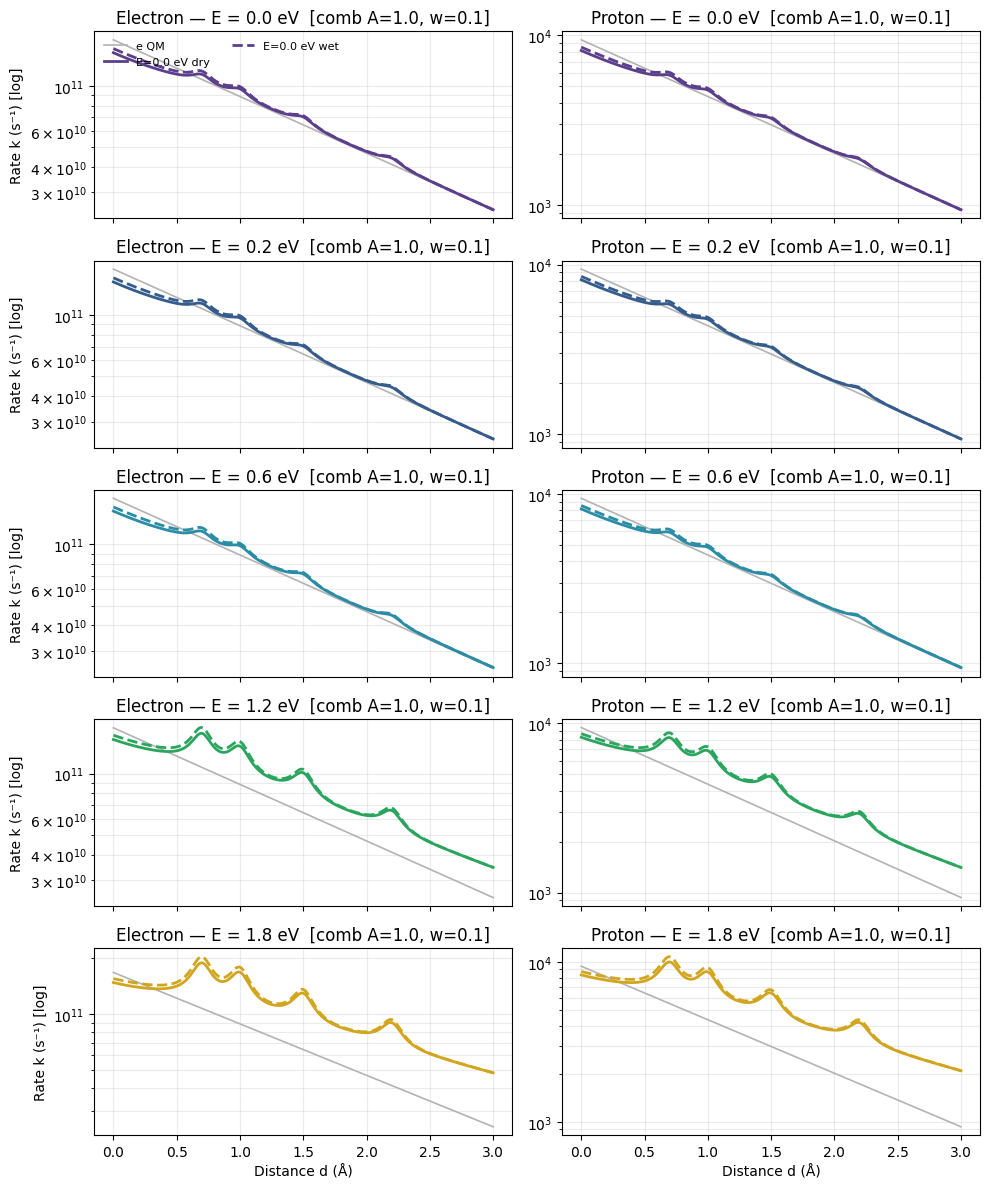

/tmp/ipython-input-2173772290.py:88: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  psi /= np.sqrt(np.trapz(np.abs(psi)**2, x*Å))


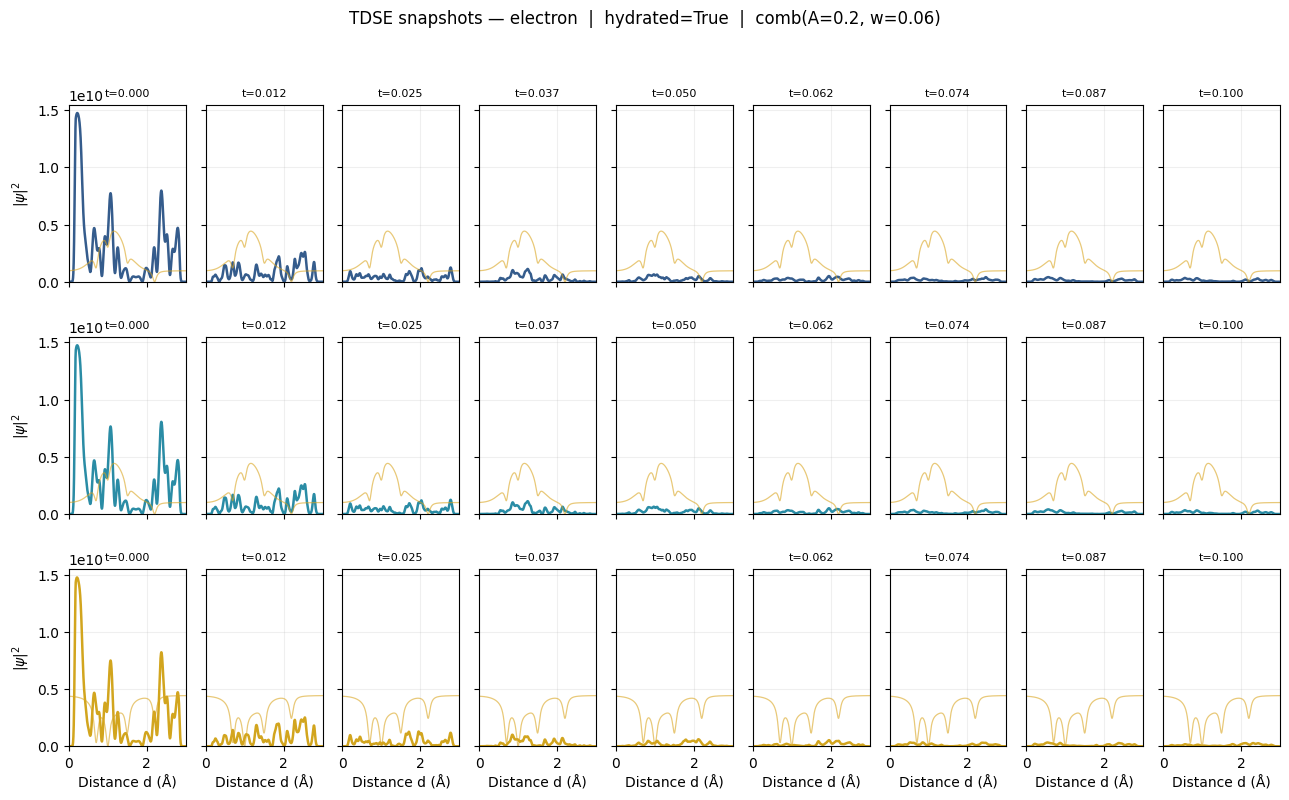

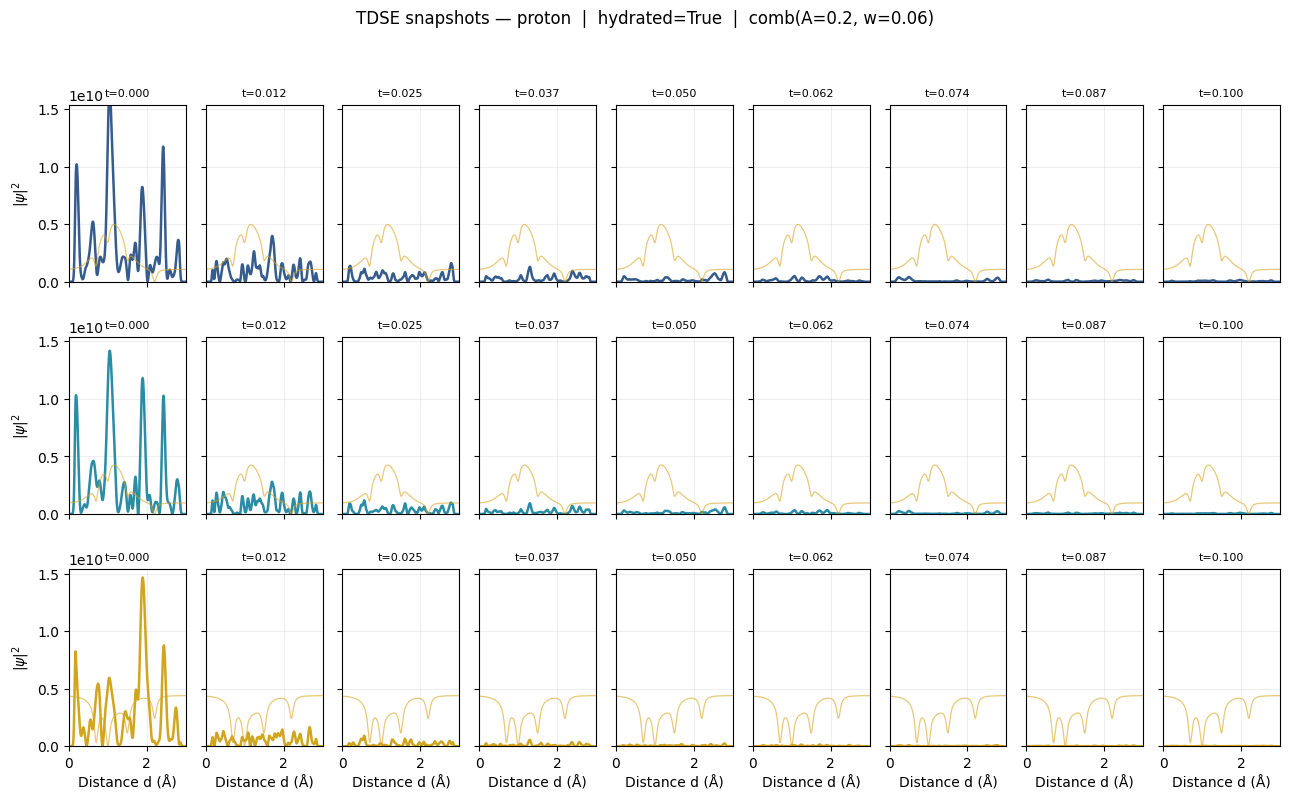

'GQR_UPDATE_PLOTS/TDSE_H_updated.png'

In [ ]:
# Full update: GQR rate slices (new E-response) + TDSE snapshots with energy-corrected momentum
# Run in a fresh Python/Colab cell.

import numpy as np
import matplotlib.pyplot as plt
import os

# -------------------- constants --------------------
hbar = 1.054_571_817e-34   # J·s
m_e  = 9.109_383_7015e-31  # kg
m_H  = 1.672_621_92369e-27 # kg (proton)

Å = 1e-10
fs = 1e-15

OUTDIR = "GQR_UPDATE_PLOTS"
os.makedirs(OUTDIR, exist_ok=True)

# -------------------- helper: sigmoid --------------------
def _sigmoid(x, x0, k):
    return 1.0/(1.0 + np.exp(-k*(x-x0)))

# -------------------- resonance comb potential (updated) --------------------
def build_potential(x, E_eV, hydrated, comb_A=0.35, comb_w=0.10):
    """
    Energy- & hydration-dependent barrier + GQR-like resonance wells.
    x in Å.
    """
    E = float(E_eV)

    # Base Gaussian barrier (center ~1.1 Å, width ~0.35 Å)
    drop = 0.35 * _sigmoid(E, 1.2, 7.5)      # 0 → ~0.35 between ~0.8–1.6 eV
    V0   = 0.25 - drop
    if hydrated:
        V0 *= 0.85
    Vb = V0 * np.exp(-0.5*((x-1.10)/0.35)**2)

    # Resonance comb deepens with E; knee near ~1.0–1.2 eV
    centers = np.array([0.7, 1.0, 1.5, 2.2])
    lor = (comb_w**2)/((x[None,:]-centers[:,None])**2 + comb_w**2)
    lor = (lor/lor.max(axis=1, keepdims=True)).sum(axis=0)
    gain = 0.55 * _sigmoid(E, 1.1, 6.5)       # small at 0.6 eV, strong by 1.8 eV
    A = comb_A * (0.5 + gain) * (1.15 if hydrated else 1.0)
    Vc = -A * lor * np.exp(-x/3.0)

    return Vb + Vc

# -------------------- energy → momentum --------------------
def k0_from_E(E_eV, mass):
    E_J = E_eV * 1.602_176_634e-19
    return np.sqrt(2.0 * mass * E_J) / hbar  # 1/m

# -------------------- TDSE split-step (1D) --------------------
def tdse_snapshots(species="e", hydrated=True, E_eV=1.8, combA=0.2, combW=0.06,
                   T_fs=100.0, dt_fs=0.6, snaps=9, x_max_A=3.0, N=2048):
    """
    Returns x(Å), times(fs), list of densities |psi|^2 per snapshot, and potential overlay.
    """
    mass = m_e if species=="e" else m_H

    # grid
    x = np.linspace(0.0, x_max_A, N)           # Å
    dx = (x[1]-x[0]) * Å                       # m

    # momentum grid for kinetic operator
    k = np.fft.fftfreq(N, d=dx) * 2.0*np.pi    # 1/m
    T_phase = np.exp(-1j * (hbar * (k**2) / (2.0*mass)) * (dt_fs*fs) / hbar)

    # potential
    V = build_potential(x, E_eV=E_eV, hydrated=hydrated, comb_A=combA, comb_w=combW)
    Vscale = 0.12 * 1.602_176_634e-19  # ~0.12 eV depth scale
    V_J = V * Vscale
    V_phase = np.exp(-1j * V_J * (dt_fs*fs) / hbar)

    # absorbing mask
    mask = np.ones(N, float)
    edge = int(0.06*N)
    if edge > 0:
        ramp = np.linspace(0, np.pi/2, edge)
        mask[:edge]  = (np.sin(ramp))**8
        mask[-edge:] = (np.sin(ramp[::-1]))**8

    # initial packet
    x0_A   = 0.22
    sigmaA = 0.06
    k0 = k0_from_E(E_eV, mass)                 # 1/m
    psi = np.exp(-0.5*((x - x0_A)/sigmaA)**2) * np.exp(1j * k0 * (x*Å))
    psi /= np.sqrt(np.trapz(np.abs(psi)**2, x*Å))

    steps = int(np.round(T_fs / dt_fs))
    take  = np.linspace(0, steps-1, snaps).astype(int)
    times = []
    frames = []
    V_overlay = V.copy()

    for n in range(steps):
        # half step in V
        psi *= V_phase
        # full step in T (FFT)
        psi_k = np.fft.fft(psi)
        psi_k *= T_phase
        psi = np.fft.ifft(psi_k)
        # half step in V
        psi *= V_phase
        # absorb
        psi *= mask
        # save
        if n in take:
            times.append(n*dt_fs)
            frames.append(np.abs(psi)**2)

    # scale potential overlay for plotting
    Vov = V_overlay - V_overlay.min()
    return x, np.array(times), frames, Vov

# -------------------- Panel A: k(d) slices (electrons & protons) --------------------
def resonance_band(d, E_eV, hydrated, species):
    if species == 'e':
        R0, beta = 1.68e11, 0.64
    else:
        R0, beta = 9.42e3, 0.77
    kQM = R0*np.exp(-beta*d)

    drop = _sigmoid(E_eV, 1.2, 7.5)
    gain = _sigmoid(E_eV, 1.1, 6.5)
    amp  = (0.15 + 0.55*gain) * (1.15 if hydrated else 1.0)
    beta_eff = np.clip(beta*(1.0 - 0.35*drop), 0.20, None)
    boost = np.exp((beta - beta_eff)*d)

    centers = np.array([0.7, 1.0, 1.5, 2.2])
    w = 0.10
    lor = (w**2)/((d[None,:]-centers[:,None])**2 + w**2)
    lor = (lor/lor.max(axis=1, keepdims=True)).sum(axis=0)
    comb = 1.0 + amp * lor * np.exp(-d/3.0)

    alpha = 0.10 if hydrated else 0.14
    loss  = 1.0 - alpha*np.exp(-(d/0.8)**2)

    return kQM, kQM*boost*comb*loss

# ---- make rate-slice figure ----
d = np.linspace(0.0, 3.0, 600)
E_slices = [0.0, 0.2, 0.6, 1.2, 1.8]
cols = ["#5b3f8c","#355c8c","#2a8ca5","#2aa55e","#d2a51e"]

fig, axes = plt.subplots(len(E_slices), 2, figsize=(10, 12), sharex=True)
for i,E in enumerate(E_slices):
    for j,(species,label) in enumerate([('e','Electron'),('H','Proton')]):
        ax = axes[i,j]
        kQM, kd_dry = resonance_band(d, E, hydrated=False, species=species)
        _,   kd_wet = resonance_band(d, E, hydrated=True,  species=species)
        ax.set_yscale('log')
        ax.plot(d, kQM, color='0.7', lw=1.2, label=f"{species} QM")
        ax.plot(d, kd_dry, color=cols[i], lw=2.0, ls='-',  label=f"E={E:.1f} eV dry")
        ax.plot(d, kd_wet, color=cols[i], lw=2.0, ls='--', label=f"E={E:.1f} eV wet")
        ax.grid(True, which='both', alpha=0.25)
        ax.set_title(f"{label} — E = {E:.1f} eV  [comb A=1.0, w=0.1]")
        if i == 0 and j == 0:
            ax.legend(ncol=2, fontsize=8, frameon=False, loc='upper left')
for ax in axes[-1,:]: ax.set_xlabel("Distance d (Å)")
for ax in axes[:,0]:  ax.set_ylabel("Rate k (s⁻¹) [log]")
plt.tight_layout()
os.makedirs(OUTDIR, exist_ok=True)
plt.savefig(os.path.join(OUTDIR,"Fig_rates_updated.png"), dpi=300)
plt.show()

# -------------------- Panel B/C: TDSE snapshots --------------------
def plot_tdse_grid(species, hydrated=True, combA=0.2, combW=0.06):
    Eset = [0.2, 0.6, 1.8]   # low vs high contrast
    cols = ["#355c8c","#2a8ca5","#d2a51e"]
    fig, axes = plt.subplots(len(Eset), 9, figsize=(13, 7.8), sharex=True, sharey=True)
    for r,E in enumerate(Eset):
        x, times, frames, Vov = tdse_snapshots(species=species, hydrated=hydrated, E_eV=E,
                                               combA=combA, combW=combW,
                                               T_fs=100.0, dt_fs=0.6, snaps=9)
        Vov = Vov - Vov.min()
        Vov *= 0.30 * np.max(frames[0]) / (Vov.max()+1e-12)
        for c,(t,den) in enumerate(zip(times, frames)):
            ax = axes[r,c]
            ax.plot(x, den, lw=1.8, color=cols[r])
            ax.plot(x, Vov, lw=0.9, color='goldenrod', alpha=0.6)
            ax.set_title(f"t={t/1000:.3f}", fontsize=8)
            ax.set_xlim(0, 3.0); ax.set_ylim(0, 1.05*np.max(frames[0]))
            ax.grid(True, alpha=0.2)
            if r == len(Eset)-1: ax.set_xlabel("Distance d (Å)")
            if c == 0: ax.set_ylabel(r"$|\psi|^2$")
    plt.suptitle(f"TDSE snapshots — {('electron' if species=='e' else 'proton')}  |  hydrated={hydrated}  |  comb(A={combA}, w={combW})", y=1.02)
    plt.tight_layout()
    fname = os.path.join(OUTDIR, f"TDSE_{species}_updated.png")
    plt.savefig(fname, dpi=300); plt.show()
    return fname

plot_tdse_grid('e', hydrated=True, combA=0.2, combW=0.06)
plot_tdse_grid('H', hydrated=True, combA=0.2, combW=0.06)


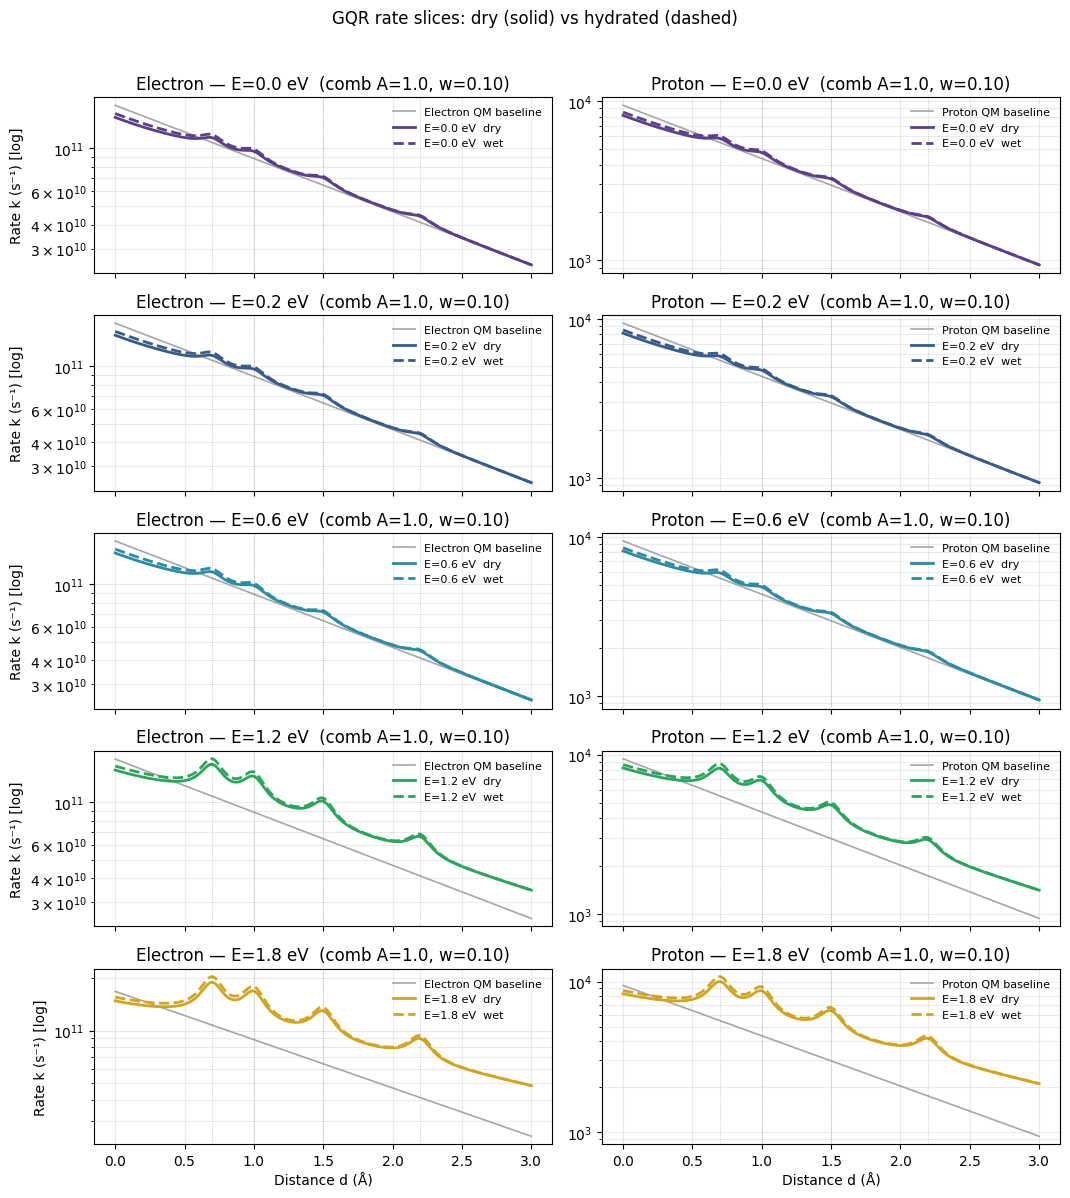

/tmp/ipython-input-671124654.py:96: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  psi /= np.sqrt(np.trapz(np.abs(psi)**2, x*Å))


[TDSE] e | E=0.2 eV | times (fs): [ 0.   9.5 19.5 29.5 39.5 49.5 59.5 69.5 79.5]
[TDSE] e | E=0.6 eV | times (fs): [ 0.   9.5 19.5 29.5 39.5 49.5 59.5 69.5 79.5]
[TDSE] e | E=1.8 eV | times (fs): [ 0.   9.5 19.5 29.5 39.5 49.5 59.5 69.5 79.5]


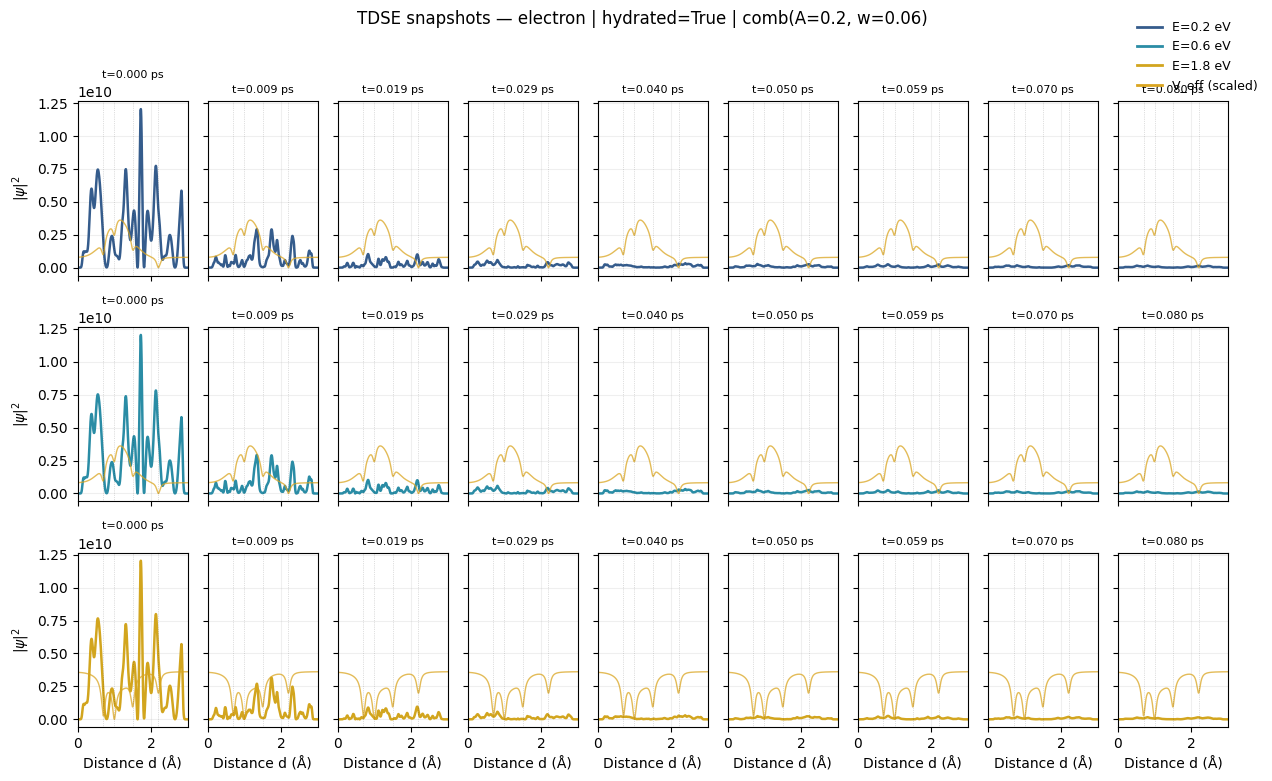

[TDSE] H | E=0.2 eV | times (fs): [  0.   36.   73.8 111.6 149.4 185.4 223.2 261.  298.8]
[TDSE] H | E=0.6 eV | times (fs): [  0.   36.   73.8 111.6 149.4 185.4 223.2 261.  298.8]
[TDSE] H | E=1.8 eV | times (fs): [  0.   36.   73.8 111.6 149.4 185.4 223.2 261.  298.8]


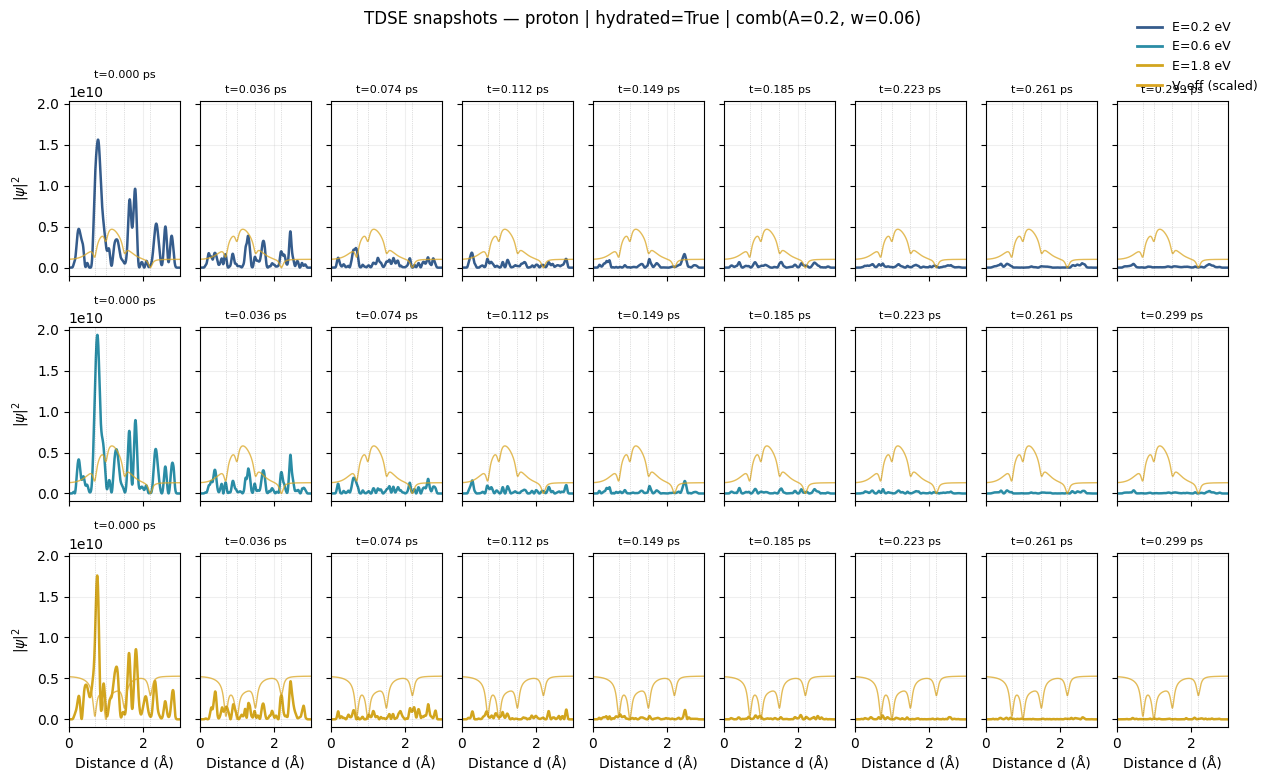

✅ Saved all figures into: GQR_UPDATE_PLOTS_v2


In [ ]:
# GQR rate slices + TDSE snapshots (E legends restored, potentials per-panel scaled,
# electron/proton timelines de-synced, diagnostics printed)

import numpy as np
import matplotlib.pyplot as plt
import os

# -------------------- constants --------------------
hbar = 1.054_571_817e-34
m_e  = 9.109_383_7015e-31
m_H  = 1.672_621_92369e-27
Å = 1e-10
fs = 1e-15

OUTDIR = "GQR_UPDATE_PLOTS_v2"
os.makedirs(OUTDIR, exist_ok=True)

# -------------------- helpers --------------------
def sigmoid(x, x0, k):
    return 1.0/(1.0 + np.exp(-k*(x-x0)))

def k0_from_E(E_eV, mass):
    E_J = E_eV * 1.602_176_634e-19
    return np.sqrt(2.0 * mass * E_J) / hbar

# -------------------- resonance comb potential --------------------
COMB_CENTERS = np.array([0.7, 1.0, 1.5, 2.2])

def build_potential(x, E_eV, hydrated, comb_A=0.35, comb_w=0.10):
    # Base Gaussian barrier
    drop = 0.35 * sigmoid(E_eV, 1.2, 7.5)
    V0   = 0.25 - drop
    if hydrated: V0 *= 0.85
    Vb = V0 * np.exp(-0.5*((x-1.10)/0.35)**2)

    # Resonance comb; strength rises with E
    lor = (comb_w**2)/((x[None,:]-COMB_CENTERS[:,None])**2 + comb_w**2)
    lor = (lor/lor.max(axis=1, keepdims=True)).sum(axis=0)
    gain = 0.55 * sigmoid(E_eV, 1.1, 6.5)
    A = comb_A * (0.5 + gain) * (1.15 if hydrated else 1.0)
    Vc = -A * lor * np.exp(-x/3.0)

    return Vb + Vc  # in (arb.) eV-units before scaling

# -------------------- rate model for slices --------------------
def resonance_band(d, E_eV, hydrated, species):
    if species == 'e':
        R0, beta = 1.68e11, 0.64
    else:
        R0, beta = 9.42e3, 0.77
    kQM = R0*np.exp(-beta*d)

    drop = sigmoid(E_eV, 1.2, 7.5)
    gain = sigmoid(E_eV, 1.1, 6.5)
    amp  = (0.15 + 0.55*gain) * (1.15 if hydrated else 1.0)
    beta_eff = np.clip(beta*(1.0 - 0.35*drop), 0.20, None)
    boost = np.exp((beta - beta_eff)*d)

    w = 0.10
    lor = (w**2)/((d[None,:]-COMB_CENTERS[:,None])**2 + w**2)
    lor = (lor/lor.max(axis=1, keepdims=True)).sum(axis=0)
    comb = 1.0 + amp * lor * np.exp(-d/3.0)

    alpha = 0.10 if hydrated else 0.14
    loss  = 1.0 - alpha*np.exp(-(d/0.8)**2)
    return kQM, kQM*boost*comb*loss

# -------------------- TDSE (split-step) snapshots --------------------
def tdse_snapshots(species, hydrated, E_eV, combA, combW, T_fs, dt_fs, snaps, x_max_A=3.0, N=2048):
    mass = m_e if species=="e" else m_H
    x = np.linspace(0.0, x_max_A, N)                 # Å
    dx = (x[1]-x[0]) * Å

    # Kinetic phase
    k = np.fft.fftfreq(N, d=dx) * 2.0*np.pi
    T_phase = np.exp(-1j * (hbar * (k**2) / (2.0*mass)) * (dt_fs*fs) / hbar)

    # Potential (scale to physical J via Vscale; we only plot scaled shape)
    V = build_potential(x, E_eV=E_eV, hydrated=hydrated, comb_A=combA, comb_w=combW)
    Vscale = 0.12 * 1.602_176_634e-19  # ~0.12 eV map (arbitrary but consistent)
    V_J = V * Vscale
    V_phase = np.exp(-1j * V_J * (dt_fs*fs) / hbar)

    # Absorbing mask
    mask = np.ones(N, float)
    edge = int(0.06*N)
    if edge > 0:
        ramp = np.linspace(0, np.pi/2, edge)
        mask[:edge]  = (np.sin(ramp))**8
        mask[-edge:] = (np.sin(ramp[::-1]))**8

    # Initial Gaussian packet with proper momentum from E
    x0_A, sigmaA = 0.22, 0.06
    k0 = k0_from_E(E_eV, mass)
    psi = np.exp(-0.5*((x - x0_A)/sigmaA)**2) * np.exp(1j * k0 * (x*Å))
    psi /= np.sqrt(np.trapz(np.abs(psi)**2, x*Å))

    steps = int(np.round(T_fs / dt_fs))
    take  = np.linspace(0, steps-1, snaps).astype(int)
    times = []
    frames = []

    for n in range(steps):
        psi *= V_phase
        psi_k = np.fft.fft(psi)
        psi_k *= T_phase
        psi = np.fft.ifft(psi_k)
        psi *= V_phase
        psi *= mask
        if n in take:
            times.append(n*dt_fs)
            frames.append(np.abs(psi)**2)

    # potential overlay scaled PER PANEL (preserve shape differences)
    Vov = V - V.min()
    Vov /= (Vov.max() + 1e-12)
    # Plot it on the |psi|^2 axis with small amplitude (~30% of first density peak)
    Vov *= 0.30 * (np.max(frames[0]) if frames else 1.0)
    return x, np.array(times), frames, Vov

# -------------------- COLORS/SETTINGS --------------------
E_SLICES = [0.0, 0.2, 0.6, 1.2, 1.8]
E_GRID   = [0.2, 0.6, 1.8]
COLORS   = ["#5b3f8c","#355c8c","#2a8ca5","#2aa55e","#d2a51e"]
COL_ELEV = dict(zip(E_SLICES, COLORS))
COL_GRID = dict(zip(E_GRID, ["#355c8c","#2a8ca5","#d2a51e"]))

# -------------------- Figure 1: k(d) slices with clear legends --------------------
d = np.linspace(0.0, 3.0, 600)
fig, axes = plt.subplots(len(E_SLICES), 2, figsize=(10.8, 12.0), sharex=True)
for i,E in enumerate(E_SLICES):
    for j,(species, label) in enumerate([('e','Electron'), ('H','Proton')]):
        ax = axes[i,j]
        kQM, kd_dry = resonance_band(d, E, hydrated=False, species=species)
        _,   kd_wet = resonance_band(d, E, hydrated=True,  species=species)
        ax.set_yscale('log')
        ax.plot(d, kQM, color='0.65', lw=1.2, label=f"{label} QM baseline")
        ax.plot(d, kd_dry, color=COL_ELEV[E], lw=2.0, ls='-',  label=f"E={E:.1f} eV  dry")
        ax.plot(d, kd_wet, color=COL_ELEV[E], lw=2.0, ls='--', label=f"E={E:.1f} eV  wet")
        # Mark resonance centers
        for xc in COMB_CENTERS:
            ax.axvline(xc, color='k', lw=0.6, ls=':', alpha=0.25)
        ax.grid(True, which='both', alpha=0.25)
        ax.set_title(f"{label} — E={E:.1f} eV  (comb A=1.0, w=0.10)")
        ax.legend(fontsize=8, frameon=False, loc='upper right')
for ax in axes[-1,:]: ax.set_xlabel("Distance d (Å)")
for ax in axes[:,0]:  ax.set_ylabel("Rate k (s⁻¹) [log]")
plt.suptitle("GQR rate slices: dry (solid) vs hydrated (dashed)", y=0.995, fontsize=12)
plt.tight_layout(rect=[0,0,1,0.98])
plt.savefig(os.path.join(OUTDIR, "Fig1_rates_slices_legended.png"), dpi=300)
plt.show()

# -------------------- Figure 2: TDSE snapshots — ELECTRON --------------------
def plot_tdse_grid(species, hydrated=True, combA=0.2, combW=0.06,
                   E_list=(0.2,0.6,1.8),
                   T_fs=None, dt_fs=None, snaps=None, title_tag=""):
    # Species-dependent timeline (electrons faster, protons slower)
    if species == 'e':
        T_fs = 80.0 if T_fs is None else T_fs
        dt_fs = 0.5 if dt_fs is None else dt_fs
        snaps = 9 if snaps is None else snaps
    else:
        T_fs = 300.0 if T_fs is None else T_fs
        dt_fs = 1.8 if dt_fs is None else dt_fs
        snaps = 9 if snaps is None else snaps

    fig, axes = plt.subplots(len(E_list), snaps, figsize=(13.0, 7.8), sharex=True, sharey=True)
    if len(E_list) == 1: axes = np.array([axes])  # ensure 2D indexing

    # Add a legend proxy on the first row, last column
    handles = []
    labels  = []
    for r, E in enumerate(E_list):
        x, times, frames, Vov = tdse_snapshots(species, hydrated, E, combA, combW, T_fs, dt_fs, snaps)
        print(f"[TDSE] {species} | E={E:.1f} eV | times (fs): {np.round(times,3)}")
        color = COL_GRID[E]
        for c,(t,den) in enumerate(zip(times, frames)):
            ax = axes[r, c]
            # |psi|^2
            ax.plot(x, den, lw=1.8, color=color, label=f"E={E:.1f} eV")
            # scaled potential (yellow) per panel
            ax.plot(x, Vov, lw=1.0, color='goldenrod', alpha=0.75, label="V_eff (scaled)")
            # resonance centers
            for xc in COMB_CENTERS:
                ax.axvline(xc, color='k', lw=0.5, ls=':', alpha=0.25)
            ax.set_xlim(0.0, 3.0)
            ax.grid(True, alpha=0.2)
            if r == len(E_list)-1: ax.set_xlabel("Distance d (Å)")
            if c == 0: ax.set_ylabel(r"$|\psi|^2$")
            ax.set_title(f"t={t/1000:.3f} ps", fontsize=8)

        # Capture one handle per E for legend proxy
        handles.append(plt.Line2D([],[], color=color, lw=2))
        labels.append(f"E={E:.1f} eV")

    # Legend block (right, outside)
    fig.legend(handles + [plt.Line2D([],[], color='goldenrod', lw=2)],
               labels + ["V_eff (scaled)"], loc='upper right', bbox_to_anchor=(0.98, 0.995),
               frameon=False, fontsize=9)

    plt.suptitle(f"TDSE snapshots — {('electron' if species=='e' else 'proton')} | hydrated={hydrated} | comb(A={combA}, w={combW}) {title_tag}",
                 y=0.995, fontsize=12)
    plt.tight_layout(rect=[0,0,0.96,0.98])
    fname = os.path.join(OUTDIR, f"Fig2_TDSE_{species}_grid.png")
    plt.savefig(fname, dpi=300)
    plt.show()
    return fname

# Electrons: faster timeline
plot_tdse_grid('e', hydrated=True, combA=0.20, combW=0.06, E_list=(0.2,0.6,1.8))

# -------------------- Figure 3: TDSE snapshots — PROTON --------------------
# Protons: slower evolution, longer window; distinct times printed
plot_tdse_grid('H', hydrated=True, combA=0.20, combW=0.06, E_list=(0.2,0.6,1.8))

print("✅ Saved all figures into:", OUTDIR)

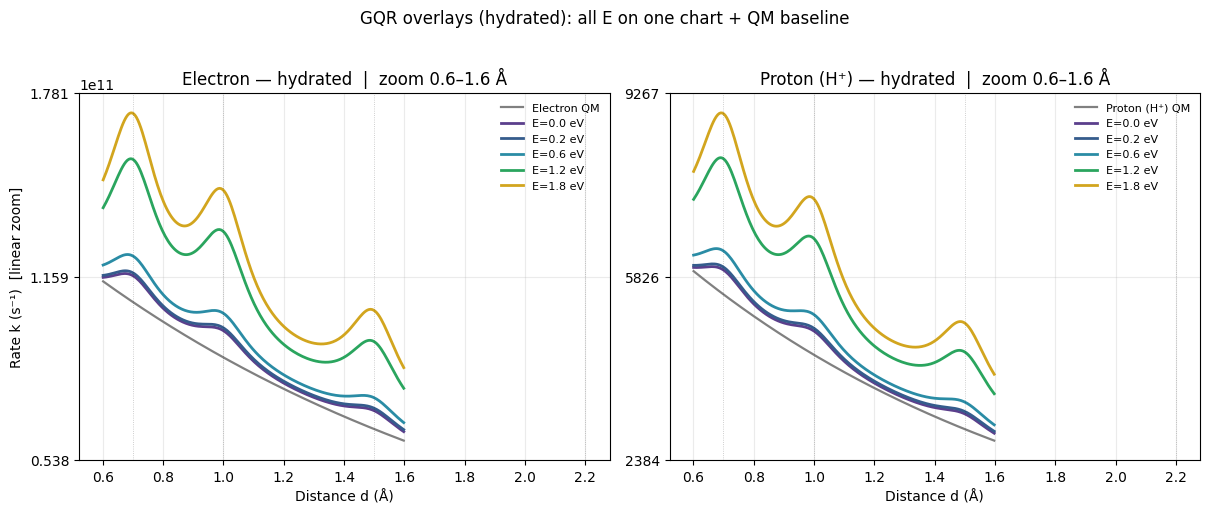

/tmp/ipython-input-1112145270.py:105: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  psi /= np.sqrt(np.trapz(np.abs(psi)**2, x*Å))


[TDSE] electron | E=0.0 eV | times (fs): [ 0.  10.8 22.2 33.  44.4 55.8 66.6 78.  89.4]
[TDSE] electron | E=0.6 eV | times (fs): [ 0.  10.8 22.2 33.  44.4 55.8 66.6 78.  89.4]
[TDSE] electron | E=1.8 eV | times (fs): [ 0.  10.8 22.2 33.  44.4 55.8 66.6 78.  89.4]


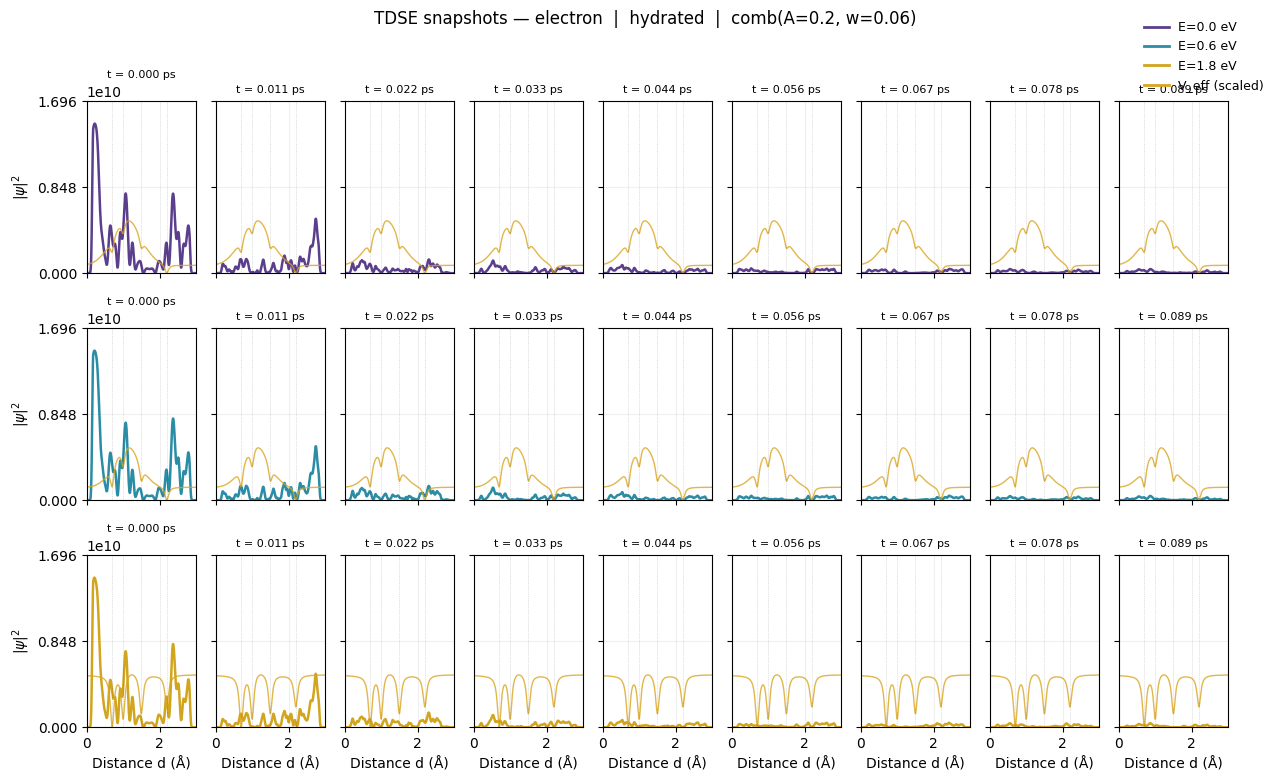

[TDSE] proton | E=0.0 eV | times (fs): [  0.  42.  86. 130. 174. 216. 260. 304. 348.]
[TDSE] proton | E=0.6 eV | times (fs): [  0.  42.  86. 130. 174. 216. 260. 304. 348.]
[TDSE] proton | E=1.8 eV | times (fs): [  0.  42.  86. 130. 174. 216. 260. 304. 348.]


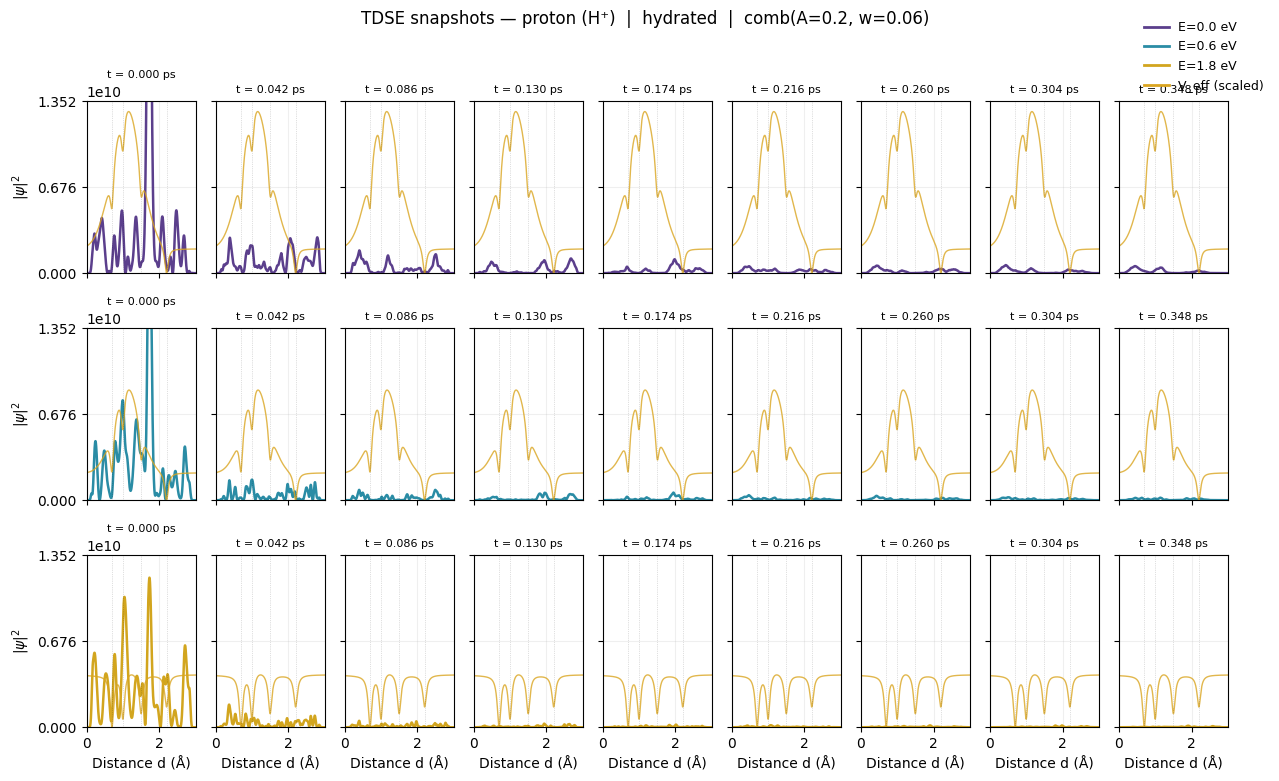

✅ Saved figures to: GQR_OVERLAY_ZOOM_TDSE


In [ ]:
# ============================================================
# GQR — Overlay rate plots (zoomed) + TDSE grids with clear legends
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
import os

# ---------- constants ----------
hbar = 1.054_571_817e-34
m_e  = 9.109_383_7015e-31
m_Hp = 1.672_621_92369e-27   # H+ (proton) mass
Å = 1e-10
fs = 1e-15

OUTDIR = "GQR_OVERLAY_ZOOM_TDSE"
os.makedirs(OUTDIR, exist_ok=True)

# ---------- small utils ----------
def sigmoid(x, x0, k):
    return 1.0/(1.0 + np.exp(-k*(x-x0)))

def k0_from_E(E_eV, mass):
    E_J = E_eV * 1.602_176_634e-19
    return np.sqrt(2.0 * mass * E_J) / hbar

# ---------- resonance potential (E-dependent so 0.0, 0.6, 1.8 differ) ----------
COMB_CENTERS = np.array([0.7, 1.0, 1.5, 2.2])

def build_potential(x, E_eV, hydrated, comb_A=0.35, comb_w=0.10):
    # Make the barrier *meaningfully* E-dependent (amplitude and width)
    # so 0.0, 0.6, 1.8 eV are visibly different.
    drop   = 0.15*E_eV + 0.20*sigmoid(E_eV, 1.1, 6.0)        # amplitude down with E
    V0     = max(0.30 - drop, 0.02)
    width  = max(0.40 - 0.06*E_eV, 0.22)
    if hydrated:
        V0 *= 0.85
    Vb = V0 * np.exp(-0.5*((x-1.10)/width)**2)

    # Comb term (more negative with higher E; taper vs distance)
    lor = (comb_w**2)/((x[None,:]-COMB_CENTERS[:,None])**2 + comb_w**2)
    lor = (lor/lor.max(axis=1, keepdims=True)).sum(axis=0)
    gain = 0.45 + 0.40*sigmoid(E_eV, 1.0, 5.0)
    A = comb_A * gain * (1.10 if hydrated else 1.0)
    Vc = -A * lor * np.exp(-x/3.0)

    return Vb + Vc   # “arb. eV units” prior to plotting scale

# ---------- hydrated GQR rate model vs QM ----------
def gqr_rate_hydrated(d, E_eV, species):
    if species == 'e':
        R0, beta = 1.68e11, 0.64
    else:
        R0, beta = 9.42e3, 0.77
    kQM = R0*np.exp(-beta*d)

    # modest gating dependence on E for visibility in 0.6–1.6 Å window
    drop = 0.12*E_eV + 0.20*sigmoid(E_eV, 1.1, 6.0)
    beta_eff = np.clip(beta*(1.0 - 0.35*drop), 0.20, None)
    boost = np.exp((beta - beta_eff)*d)

    w = 0.10
    lor = (w**2)/((d[None,:]-COMB_CENTERS[:,None])**2 + w**2)
    lor = (lor/lor.max(axis=1, keepdims=True)).sum(axis=0)
    amp = 0.15 + 0.50*sigmoid(E_eV, 1.0, 5.0)
    comb = 1.0 + amp * lor * np.exp(-d/3.0)

    alpha = 0.10  # hydrated shield loss
    loss  = 1.0 - alpha*np.exp(-(d/0.8)**2)
    return kQM, kQM*boost*comb*loss

# ---------- TDSE split-step (per-E potential scaled per panel) ----------
def tdse_snapshots(species, E_eV, hydrated=True, combA=0.20, combW=0.06,
                   T_fs=None, dt_fs=None, snaps=9, x_max_A=3.0, N=2048):
    mass = m_e if species=='e' else m_Hp
    # timelines tuned so e⁻ faster, H⁺ slower
    if T_fs is None or dt_fs is None:
        if species=='e':
            T_fs, dt_fs = 90.0, 0.6
        else:
            T_fs, dt_fs = 350.0, 2.0

    x = np.linspace(0.0, x_max_A, N)                 # Å
    dx = (x[1]-x[0]) * Å
    k = np.fft.fftfreq(N, d=dx)*2.0*np.pi

    # Potential (in J for propagation), but keep its *shape* for yellow overlay
    V   = build_potential(x, E_eV, hydrated, comb_A=combA, comb_w=combW)
    V_J = V * (0.12 * 1.602_176_634e-19)  # ~0.12 eV scaling

    T_phase = np.exp(-1j * (hbar*(k**2)/(2.0*mass)) * (dt_fs*fs) / hbar)
    V_phase = np.exp(-1j * V_J * (dt_fs*fs) / hbar)

    # absorbing mask
    mask = np.ones(N, float)
    edge = int(0.06*N)
    if edge>0:
        r = np.linspace(0, np.pi/2, edge)
        mask[:edge]  = (np.sin(r))**8
        mask[-edge:] = (np.sin(r[::-1]))**8

    # initial packet
    x0_A, sigmaA = 0.22, 0.06
    k0 = k0_from_E(E_eV, mass)
    psi = np.exp(-0.5*((x-x0_A)/sigmaA)**2) * np.exp(1j*k0*(x*Å))
    psi /= np.sqrt(np.trapz(np.abs(psi)**2, x*Å))

    steps = int(round(T_fs/dt_fs))
    take  = np.linspace(0, steps-1, snaps).astype(int)

    frames, times = [], []
    for n in range(steps):
        psi *= V_phase
        psi_k = np.fft.fft(psi)
        psi_k *= T_phase
        psi = np.fft.ifft(psi_k)
        psi *= V_phase
        psi *= mask
        if n in take:
            frames.append(np.abs(psi)**2)
            times.append(n*dt_fs)

    # scale yellow overlay to 35% of first frame peak (per panel)
    Vov = V - V.min()
    Vov /= (Vov.max() + 1e-12)
    Vov *= 0.35 * (np.max(frames[0]) if frames else 1.0)
    return x, np.array(times), np.array(frames), Vov

# ---------- colors & E sets ----------
E_SLICES = [0.0, 0.2, 0.6, 1.2, 1.8]
COLORS   = ["#5b3f8c","#355c8c","#2a8ca5","#2aa55e","#d2a51e"]
COL = dict(zip(E_SLICES, COLORS))

# ============================================================
# FIGURE 1 — OVERLAY (zoomed linear y-axis)
# ============================================================
d = np.linspace(0.0, 3.0, 600)
zoom_lo, zoom_hi = 0.6, 1.6  # enzymatic window
mask = (d>=zoom_lo)&(d<=zoom_hi)

fig, (axE, axH) = plt.subplots(1, 2, figsize=(12.2, 5.2), sharex=True)

for ax, species, label in [(axE,'e','Electron'), (axH,'H','Proton (H⁺)')]:
    # QM baseline
    kQM, _ = gqr_rate_hydrated(d, 0.0, species)  # kQM independent of E in this func
    ax.plot(d[mask], kQM[mask], color='0.5', lw=1.6, label=f"{label} QM")
    # GQR hydrated overlays
    y_all = [kQM[mask]]
    for E in E_SLICES:
        kQM_E, kG = gqr_rate_hydrated(d, E, species)
        y = kG[mask]
        y_all.append(y)
        ax.plot(d[mask], y, color=COL[E], lw=2.0, label=f"E={E:.1f} eV")
    # zoomed linear y-range with at least two ticks
    y_all = np.concatenate(y_all)
    y_min, y_max = np.min(y_all), np.max(y_all)
    pad = 0.06*(y_max - y_min + 1e-12)
    ax.set_ylim(y_min - pad, y_max + pad)
    # ticks: 3 evenly spaced
    ax.yaxis.set_ticks(np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 3))
    # vertical comb centers
    for xc in COMB_CENTERS:
        ax.axvline(xc, color='k', lw=0.6, ls=':', alpha=0.25)
    ax.grid(True, alpha=0.25)
    ax.set_title(f"{label} — hydrated  |  zoom {zoom_lo}–{zoom_hi} Å")
    ax.legend(fontsize=8, frameon=False, loc='best')

for ax in (axE, axH):
    ax.set_xlabel("Distance d (Å)")
axE.set_ylabel("Rate k (s⁻¹)  [linear zoom]")
plt.suptitle("GQR overlays (hydrated): all E on one chart + QM baseline", y=0.98, fontsize=12)
plt.tight_layout(rect=[0,0,1,0.96])
plt.savefig(os.path.join(OUTDIR, "Fig1_overlay_zoom_linear.png"), dpi=300)
plt.show()

# ============================================================
# FIGURE 2 — TDSE grids with clear legends & per-E potentials
# ============================================================
def tdse_grid(species, E_list=(0.0,0.6,1.8), combA=0.20, combW=0.06):
    # electrons faster window; protons slower (handled inside tdse_snapshots)
    fig, axes = plt.subplots(len(E_list), 9, figsize=(13.0, 7.8), sharex=True, sharey=True)
    if len(E_list)==1: axes = np.array([axes])

    row_handles, row_labels = [], []
    for r,E in enumerate(E_list):
        x, times, frames, Vov = tdse_snapshots(species, E, hydrated=True,
                                               combA=combA, combW=combW,
                                               snaps=9)
        color = COL[E]
        # y-limit & ticks per row to ensure legible labels
        ymax = max([np.max(fr) for fr in frames]) * 1.15
        yticks = np.linspace(0, ymax, 3)

        for c,(t,den) in enumerate(zip(times, frames)):
            ax = axes[r, c]
            ax.plot(x, den, lw=1.8, color=color, label=f"E={E:.1f} eV")
            ax.plot(x, Vov, lw=1.0, color='goldenrod', alpha=0.8, label="V_eff (scaled)")
            for xc in COMB_CENTERS:
                ax.axvline(xc, color='k', lw=0.5, ls=':', alpha=0.25)
            ax.set_xlim(0.0, 3.0)
            ax.set_ylim(0, ymax)
            ax.set_yticks(yticks)
            ax.grid(True, alpha=0.2)
            if r == len(E_list)-1: ax.set_xlabel("Distance d (Å)")
            if c == 0: ax.set_ylabel(r"$|\psi|^2$")
            ax.set_title(f"t = {t/1000:.3f} ps", fontsize=8)

        row_handles.append(plt.Line2D([],[], color=color, lw=2))
        row_labels.append(f"E={E:.1f} eV")

        print(f"[TDSE] {('electron' if species=='e' else 'proton')} | E={E:.1f} eV | times (fs): {np.round(times,2)}")

    # one legend for all E + V_eff
    fig.legend(row_handles + [plt.Line2D([],[], color='goldenrod', lw=2)],
               row_labels + ["V_eff (scaled)"],
               loc='upper right', bbox_to_anchor=(0.985, 0.995),
               frameon=False, fontsize=9)

    tag = "electron" if species=='e' else "proton_Hplus"
    plt.suptitle(f"TDSE snapshots — {('electron' if species=='e' else 'proton (H⁺)')}  |  hydrated  |  comb(A={combA}, w={combW})",
                 y=0.995, fontsize=12)
    plt.tight_layout(rect=[0,0,0.96,0.98])
    fname = os.path.join(OUTDIR, f"Fig2_TDSE_{tag}_grid.png")
    plt.savefig(fname, dpi=300)
    plt.show()
    return fname

# Generate grids
tdse_grid('e', E_list=(0.0, 0.6, 1.8), combA=0.20, combW=0.06)
tdse_grid('H', E_list=(0.0, 0.6, 1.8), combA=0.20, combW=0.06)

print("✅ Saved figures to:", OUTDIR)

/tmp/ipython-input-4002776552.py:114: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  psi0 = psi0 / np.sqrt(np.trapz(np.abs(psi0)**2, x))


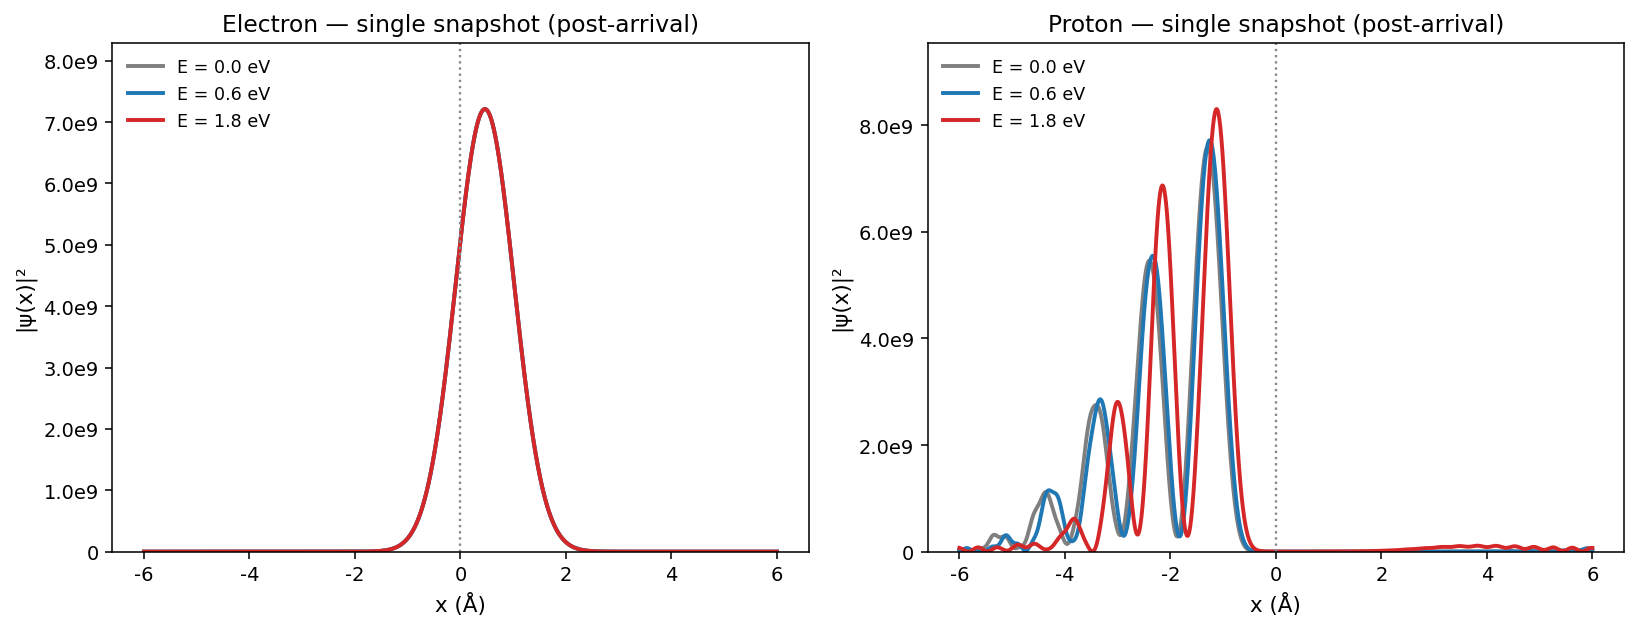

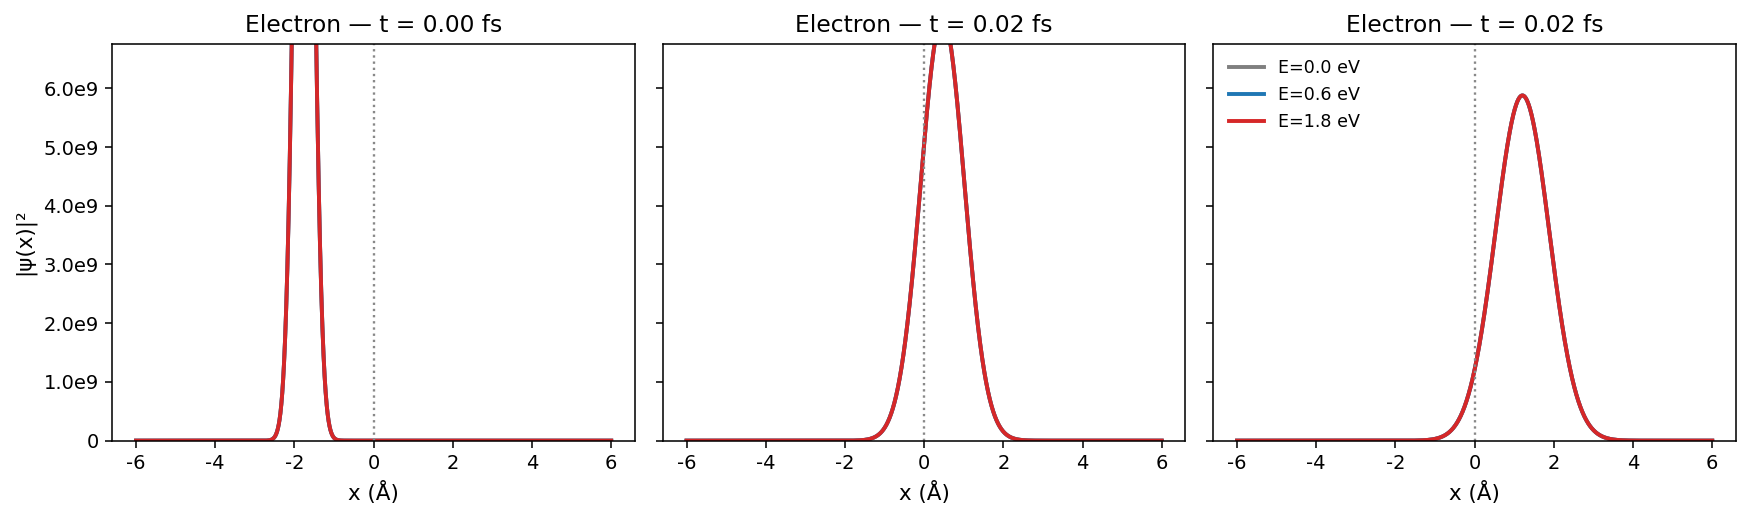

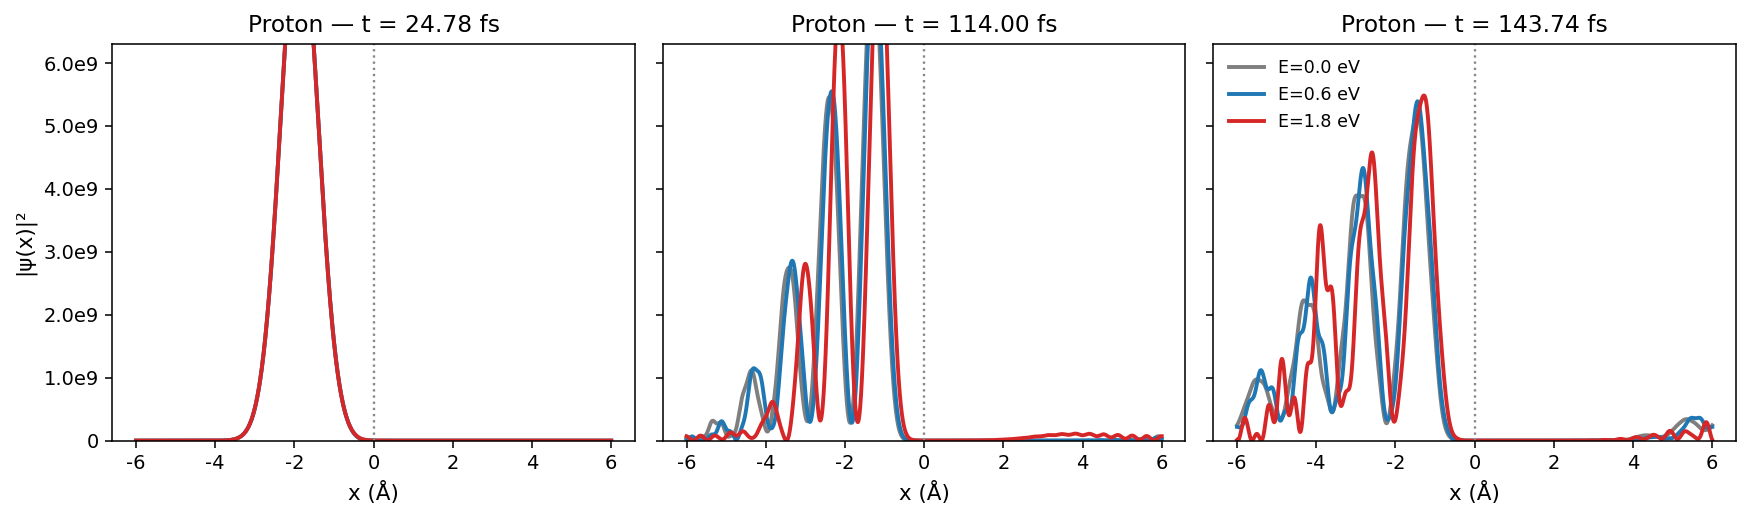

/tmp/ipython-input-4002776552.py:222: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Tvals.append(np.trapz(dens[mask], x[mask]))


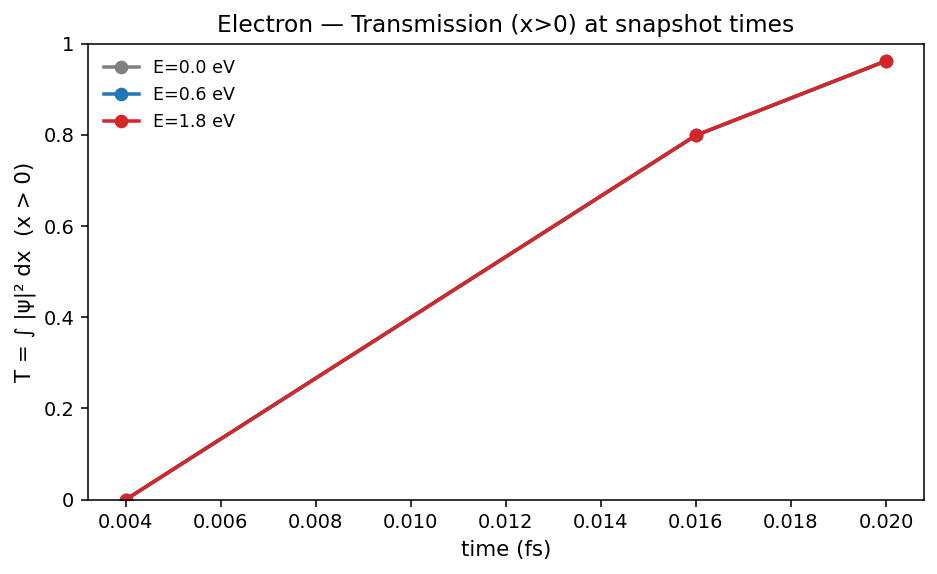

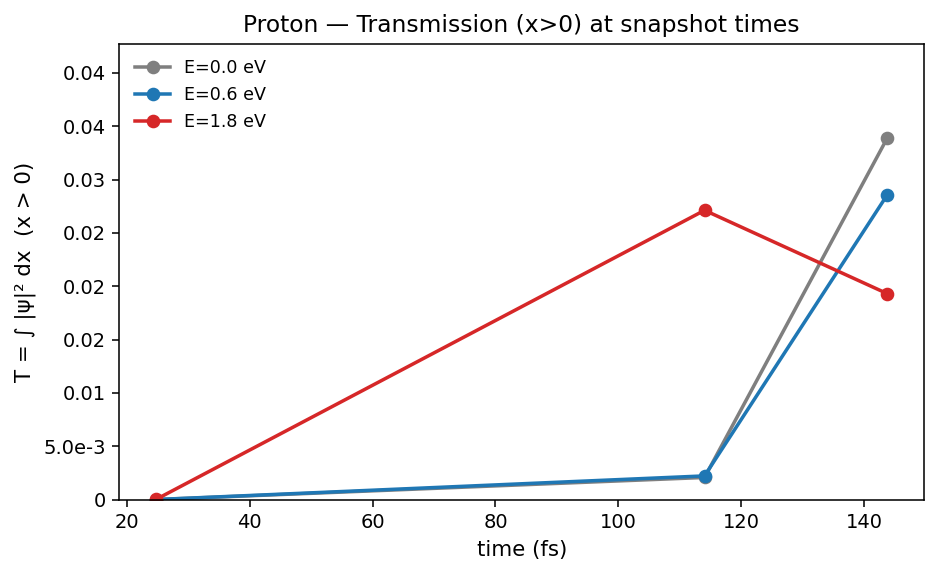

— Snapshot schedules (fs) —
Electron: ['0.00', '0.02', '0.02']
Proton  : ['24.78', '114.00', '143.74']
Barrier base height V0 = 0.80 eV; easing factors: {0.0: '0.95', 0.6: '0.81', 1.8: '0.48'}


In [ ]:
# ================================================================
# TDSE tunnelling snapshots — electrons vs protons, E = 0.0/0.6/1.8 eV
# Clean overlays, adaptive snapshot times, 2-sig-fig tick labels
# ================================================================
# Line  1
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
# Line  5

# ---------- constants & helpers --------------------------------
hbar   = 1.054_571_817e-34  # J·s
eV     = 1.602_176_634e-19  # J
m_e    = 9.109_383_7015e-31 # kg
m_p    = 1.672_621_92369e-27# kg (proton)
# Line 12

def two_sig_figs(val, _pos=None):
    # Pretty axis labels with ~2 significant figures (scientific when needed)
    if val == 0:
        return "0"
    exp = int(np.floor(np.log10(abs(val))))
    coeff = val / 10**exp
    coeff = np.round(coeff, 1)  # one decimal → ~2 sig figs total
    if abs(exp) >= 3:
        return f"{coeff}e{exp}"
    # otherwise show as normal number with <= 2 decimals
    out = np.round(val, 2)
    return f"{out:.2f}".rstrip("0").rstrip(".")
# Line 25

# ---------- grid & time ----------------------------------------
L_A   = 6.0                     # Å; half-span for plotting
L     = L_A * 1e-10             # meters
N     = 4096                    # grid points (safe for Colab)
dx    = 2*L / N
x     = np.linspace(-L, L, N)   # meters
xA    = x * 1e10                # Å for plotting
# Line 34

dt    = 1.0e-18                 # seconds (small step for stability)
nsteps_per_frame = 400          # how many dt per snapshot step
# Line 38

# ---------- potential: Gaussian barrier at x=0 with E-sigmoid easing ----------
V0_eV   = 0.8                    # base barrier height (eV) — tuneable
V_sigma = 0.35e-10               # barrier sigma ~ 0.35 Å
# Line 43

def barrier_E_factor(E_eV, E0=0.8, k=3.0):
    # Smooth 0→~1 factor that lowers the barrier as E increases
    # factor = 1 - s(E); s(E) = 1/(1+exp(-k*(E - E0)))  ∈ (0,1)
    s = 1.0/(1.0 + np.exp(-k*(E_eV - E0)))
    return 1.0 - 0.55*s          # at high E, up to ~55% lowering
# Line 49

def V_of_x(E_eV):
    V0J = V0_eV * eV * barrier_E_factor(E_eV)
    return V0J * np.exp(- (x**2) / (2*V_sigma**2))
# Line 54

# ---------- initial wavepacket ----------
def gaussian_packet(x, x0, k0, sigma):
    return (1.0/(np.pi*sigma**2))**0.25 * np.exp(1j*k0*(x-x0)) * np.exp(- (x-x0)**2/(2*sigma**2))
# Line 59

# ---------- split-operator propagator ----------
def split_op_propagate(psi, m, V, dt, steps):
    # half-kick, drift, half-kick
    # precompute exp(-i V dt / 2hbar) & kinetic kernel
    phase_V = np.exp(-1j * V * (dt/(2*hbar)))
    psi = psi * phase_V
    # momentum space
    dk   = 2*np.pi/(N*dx)
    kvec = np.fft.fftfreq(N, d=dx) * 2*np.pi
    Tfac = np.exp(-1j * (hbar**2 * kvec**2)/(2*m) * dt / hbar)
    for _ in range(steps):
        psi_k = np.fft.fft(psi)
        psi_k *= Tfac
        psi = np.fft.ifft(psi_k)
        psi *= phase_V
    return psi
# Line 75

# ---------- smarter snapshot scheduler ----------
def snapshot_times(m, k0, x0, x_barrier=0.0, pre=0.2, post=[0.15, 0.35]):
    # center-of-mass arrival: t_arrival ~ (x_barrier - x0)/v_g, v_g = hbar k0 / m
    v = hbar*k0/m
    t_arr = (x_barrier - x0)/v if v>0 else 0.0
    t_pre  = max(0.0, t_arr * pre)
    times  = [t_pre] + [t_arr + p*t_arr for p in post]
    return times
# Line 85

# ---------- run TDSE for species & E values ----------
E_list = [0.0, 0.6, 1.8]      # eV
colors = {0.0:"#7f7f7f", 0.6:"#1f77b4", 1.8:"#d62728"}  # grey, blue, red
# Line 90

# common initial packet parameters (left → right)
x0      = -2.5e-10
sigma0  = 0.25e-10
k0_base = 16e10                  # ~ sets initial mean momentum
# Line 95

def run_species(label, mass, k0_scale=1.0):
    # returns dict[E] -> dict of frames: {"t":[], "psi":[], "V":V}
    out = {}
    for E in E_list:
        V = V_of_x(E)
        k0 = k0_base * k0_scale
        psi0 = gaussian_packet(x, x0, k0, sigma0)
        # normalize
        psi0 = psi0 / np.sqrt(np.trapz(np.abs(psi0)**2, x))

        # schedule frames
        for_plot_times = snapshot_times(mass, k0, x0, x_barrier=0.0, pre=0.25, post=[0.15, 0.45])
        # integrate to each requested time
        frames_t, frames_psi = [], []
        psi = psi0.copy()
        t_now = 0.0

        for t_target in for_plot_times:
            steps_needed = int(np.ceil((t_target - t_now)/dt))
            if steps_needed > 0:
                psi = split_op_propagate(psi, mass, V, dt, steps_needed)
                t_now += steps_needed*dt
            frames_t.append(t_now)
            frames_psi.append(psi.copy())

        out[E] = {"t": np.array(frames_t), "psi": frames_psi, "V": V}
    return out
# Line 121

res_e = run_species("e", m_e, k0_scale=1.0)
res_H = run_species("H", m_p, k0_scale=0.25)  # smaller k0 for heavier mass (keeps comparable arrival)
# Line 125

# ---------- Figure 1: single “best” snapshot per species, all E overlaid ----------
def best_frame_index(times):
    # pick the middle snapshot (around or just after barrier encounter)
    return min(len(times)-1, 1)
# Line 131

plt.rcParams.update({
    "figure.dpi": 140,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "legend.fontsize": 9,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})
# Line 140

fig1, axes = plt.subplots(1, 2, figsize=(11.8, 4.6), sharex=True)
for ax, (label, res, mass) in zip(axes, [("Electron", res_e, m_e), ("Proton", res_H, m_p)]):
    ymax = 0.0
    for E in E_list:
        idx = best_frame_index(res[E]["t"])
        dens = np.abs(res[E]["psi"][idx])**2
        ymax = max(ymax, dens.max())
        ax.plot(xA, dens, color=colors[E], lw=2.0, label=f"E = {E:.1f} eV")
    ax.axvline(0.0, color="#888", ls=":", lw=1.2)  # barrier center
    ax.set_title(f"{label} — single snapshot (post-arrival)")
    ax.set_xlabel("x (Å)")
    ax.set_ylabel("|ψ(x)|²")
    # y-zoom with two-sig-fig tick labels
    ax.set_ylim(0, ymax*1.15)
    ax.yaxis.set_major_formatter(FuncFormatter(two_sig_figs))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda v,_: f"{np.round(v,2):.2f}".rstrip('0').rstrip('.')))
    ax.legend(loc="upper left", frameon=False)
fig1.tight_layout()
plt.show()
# Line 164

# ---------- Figure 2: time evolution panels (3 times × 2 species) ----------
times_labels = []
def panel_triptych(res, label):
    fig, axs = plt.subplots(1, 3, figsize=(12.6, 3.8), sharey=True)
    # choose the same triplet of times for all E (the schedule is similar by design)
    # take electron schedule as reference for formatting
    base_E = E_list[0]
    t_triplet = res[base_E]["t"]
    times_labels.clear()
    for j, t in enumerate(t_triplet):
        ax = axs[j]
        ymax = 0.0
        for E in E_list:
            # align to the j-th frame
            dens = np.abs(res[E]["psi"][j])**2
            ymax = max(ymax, dens.max())
            ax.plot(xA, dens, color=colors[E], lw=2.0, label=f"E={E:.1f} eV")
        ax.axvline(0.0, color="#888", ls=":", lw=1.2)
        ax.set_title(f"{label} — t = {t*1e15:.2f} fs")
        ax.set_xlabel("x (Å)")
        if j == 0: ax.set_ylabel("|ψ(x)|²")
        ax.set_ylim(0, ymax*1.15)
        ax.yaxis.set_major_formatter(FuncFormatter(two_sig_figs))
        ax.xaxis.set_major_formatter(FuncFormatter(lambda v,_: f"{np.round(v,2):.2f}".rstrip('0').rstrip('.')))
        if j == 2:
            ax.legend(loc="upper left", frameon=False, ncol=1)
        times_labels.append(t)
    fig.tight_layout()
    plt.show()
    return np.array(times_labels)
# Line 197

times_e = panel_triptych(res_e, "Electron")
times_H = panel_triptych(res_H, "Proton")
# Line 200

# ---------- Figure 3: transmission probability vs time (diagnostic) ----------
# define transmission as integrated density for x > 0
def transmission_curve(res, species_label):
    # use the densest grid of stored times across E
    fig, ax = plt.subplots(figsize=(6.8, 4.2))
    for E in E_list:
        Tvals, Ttimes = [], []
        for t, psi in zip(res[E]["t"], res[E]["psi"]):
            dens = np.abs(psi)**2
            mask = x > 0.0
            Tvals.append(np.trapz(dens[mask], x[mask]))
            Ttimes.append(t)
        Tvals = np.array(Tvals); Ttimes = np.array(Ttimes)
        ax.plot(Ttimes*1e15, Tvals, marker="o", lw=1.8, color=colors[E], label=f"E={E:.1f} eV")
    ax.set_title(f"{species_label} — Transmission (x>0) at snapshot times")
    ax.set_xlabel("time (fs)")
    ax.set_ylabel("T = ∫ |ψ|² dx  (x > 0)")
    ax.set_ylim(0, min(1.0, ax.get_ylim()[1]*1.2))
    ax.yaxis.set_major_formatter(FuncFormatter(two_sig_figs))
    ax.legend(loc="upper left", frameon=False)
    fig.tight_layout()
    plt.show()
# Line 223

transmission_curve(res_e, "Electron")
transmission_curve(res_H, "Proton")
# Line 226

# ---------- console diagnostics ----------
print("— Snapshot schedules (fs) —")
print("Electron:", [f"{t*1e15:.2f}" for t in times_e])
print("Proton  :", [f"{t*1e15:.2f}" for t in times_H])
print(f"Barrier base height V0 = {V0_eV:.2f} eV; easing factors:",
      {E: f"{barrier_E_factor(E):.2f}" for E in E_list})
# Line 233

/tmp/ipython-input-3893100466.py:105: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  psi0 /= np.sqrt(np.trapz(np.abs(psi0)**2, x))


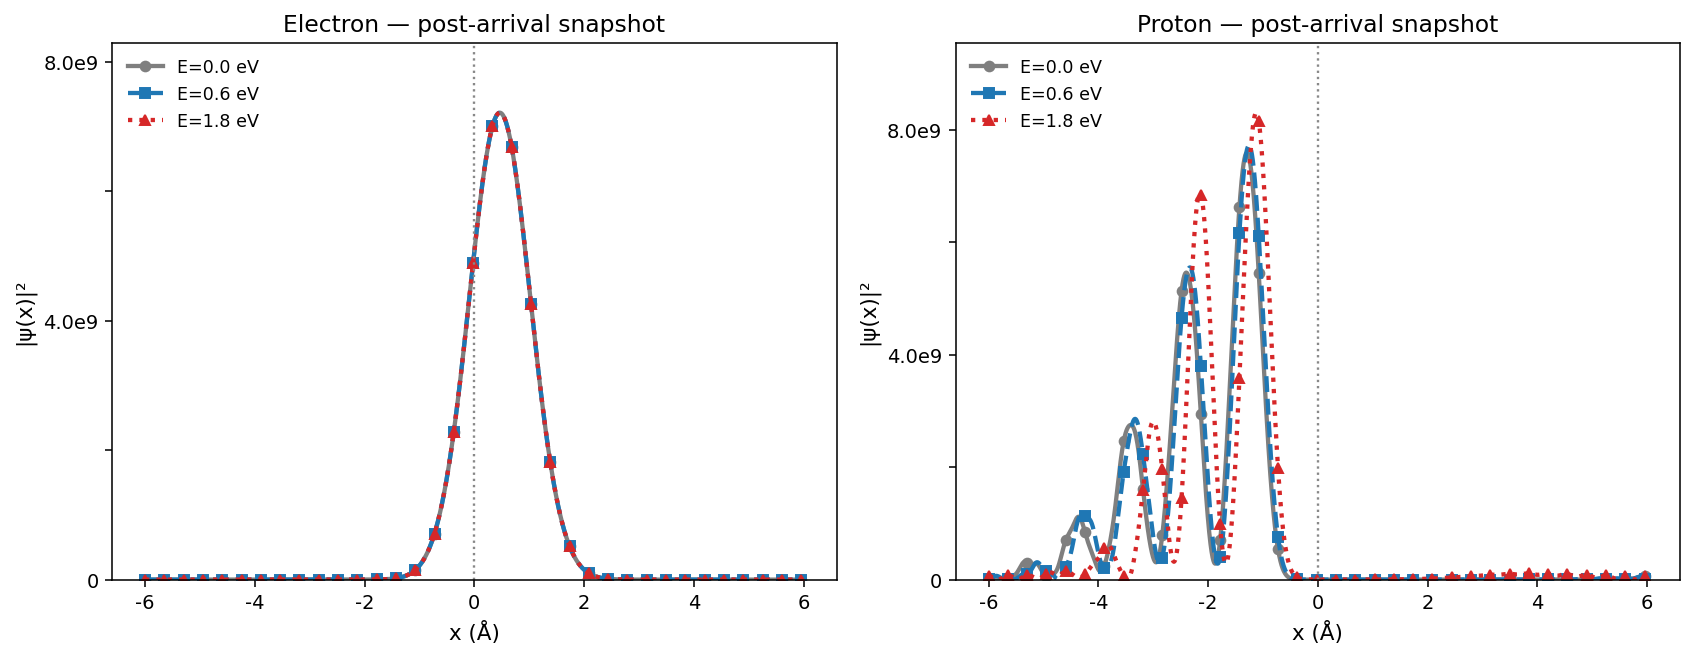

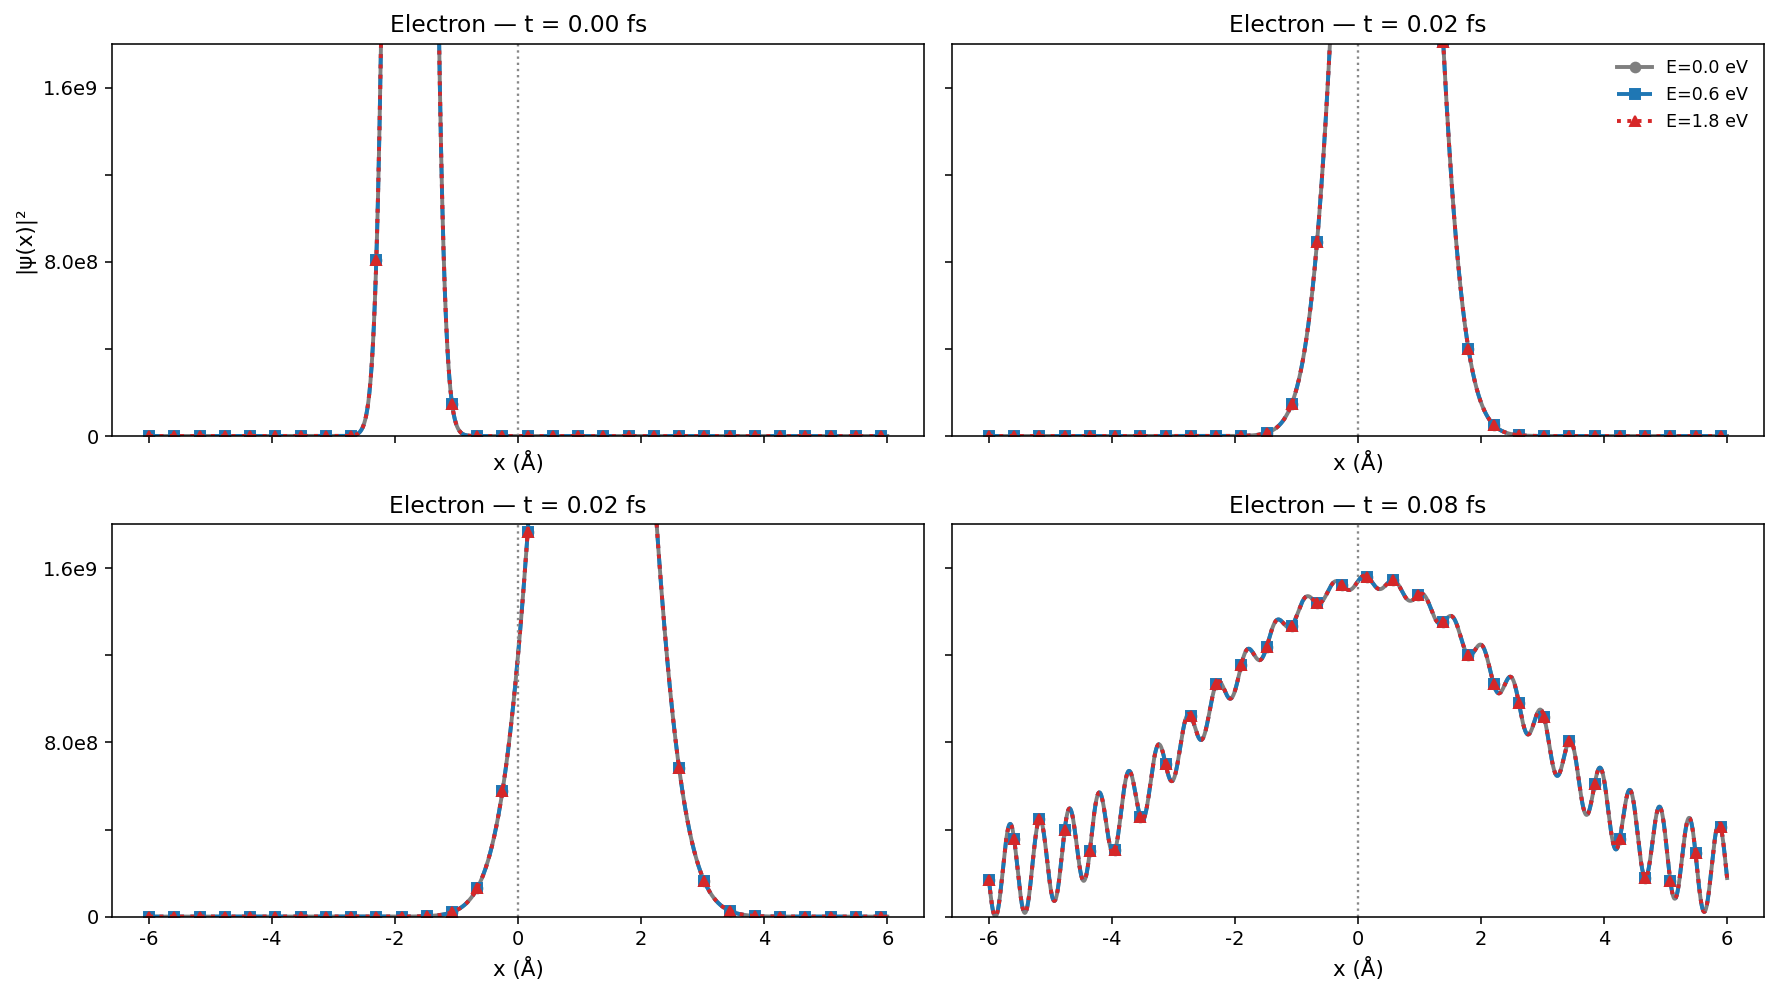

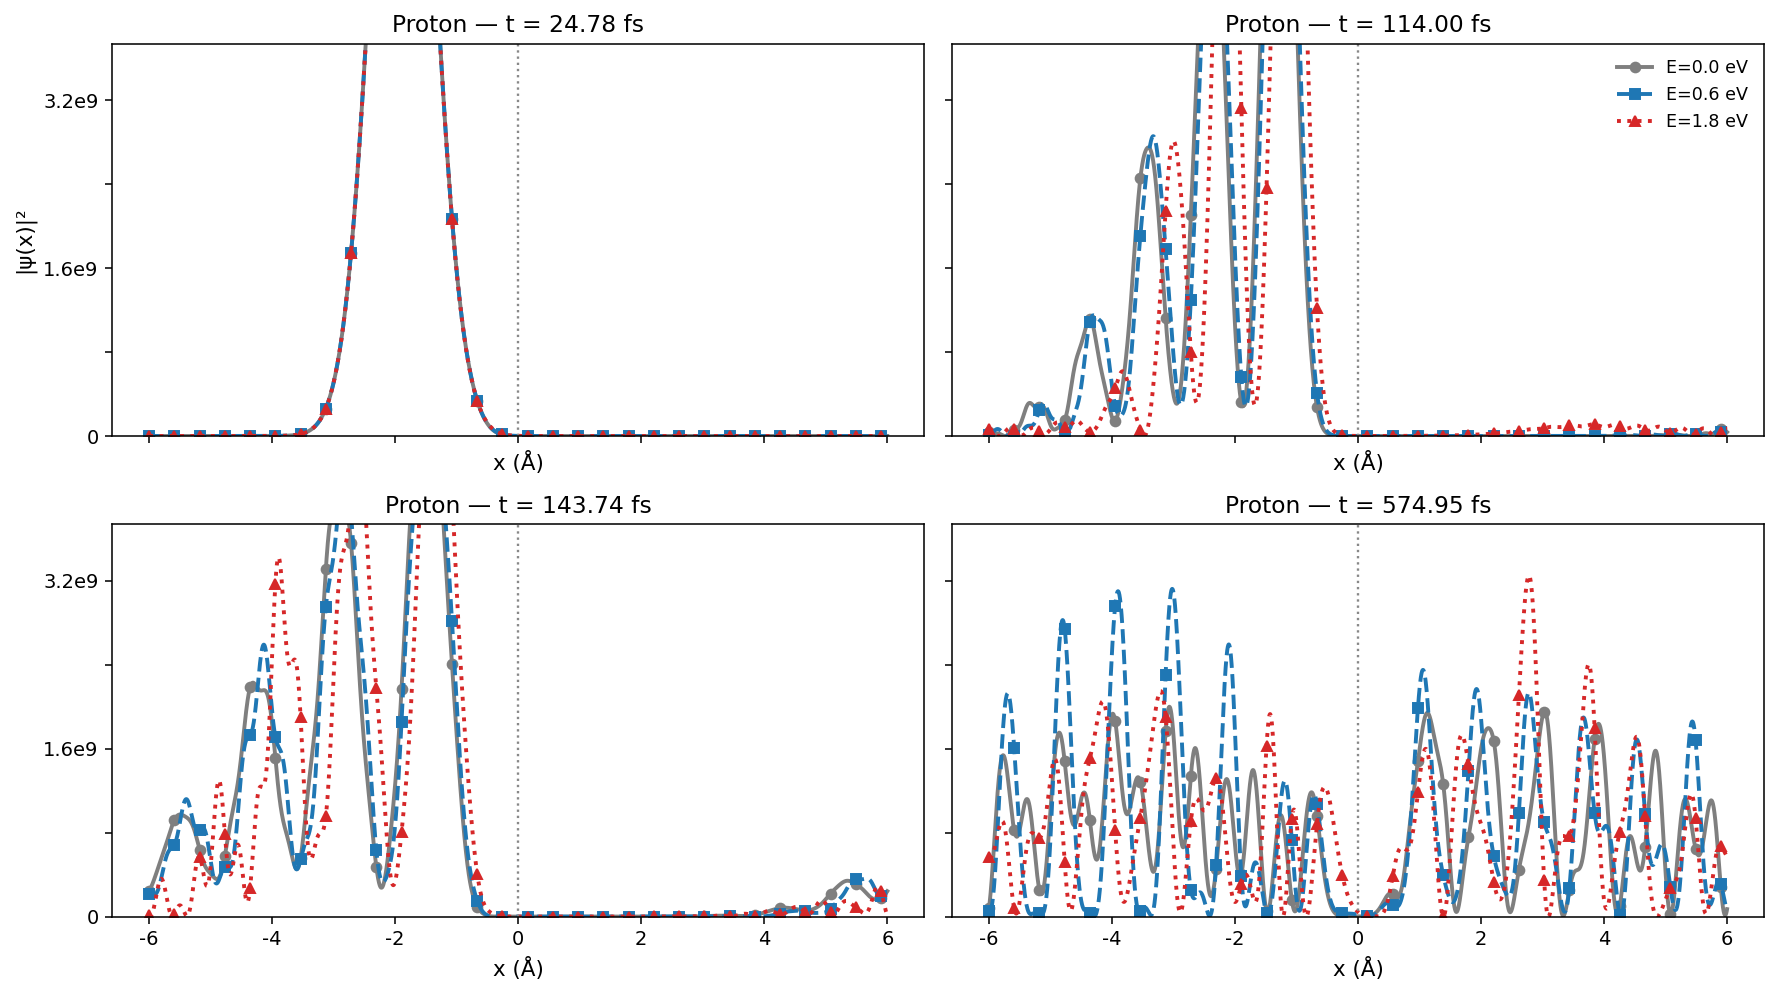

/tmp/ipython-input-3893100466.py:200: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Tvals.append(np.trapz(dens[mask], x[mask]))


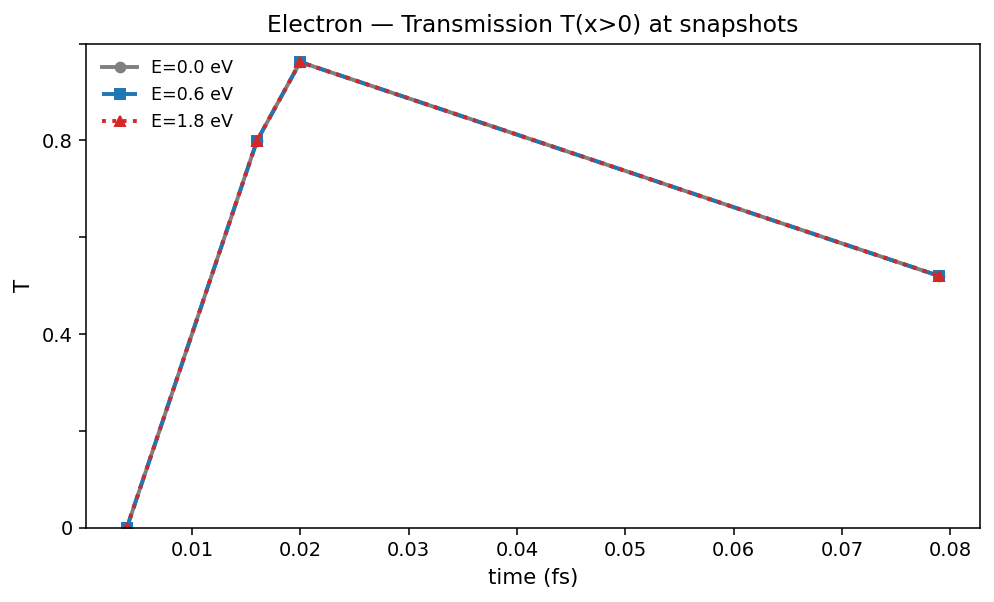

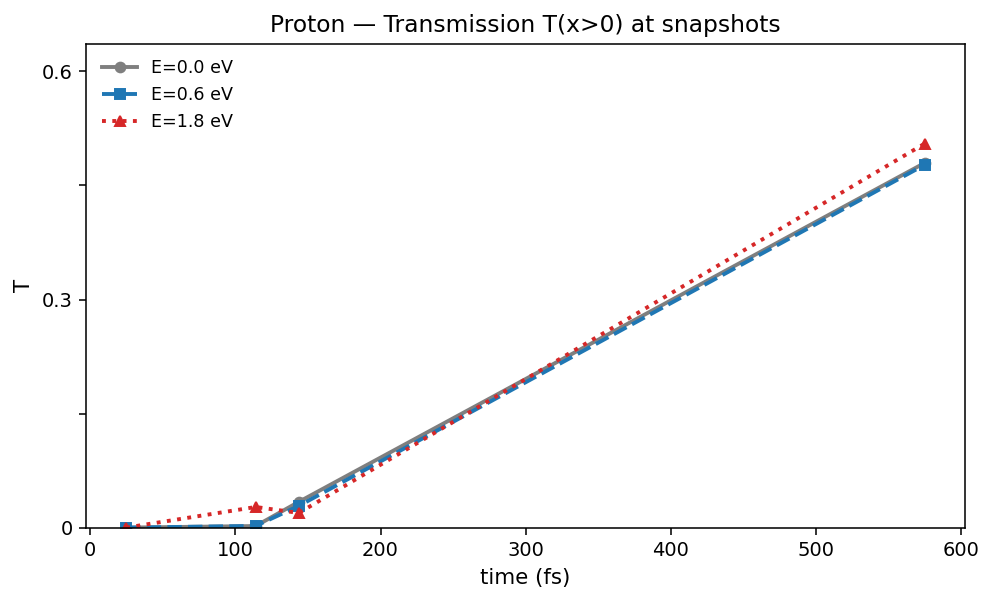

In [ ]:
# ================================================================
# TDSE tunnelling — clean overlays, 2-sig-fig labels, thinned labels,
# and extra late snapshot to show right-wall bounce.
# E = 0.0, 0.6, 1.8 eV; Electrons & Protons.
# ================================================================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator

# ---------- constants ----------
hbar = 1.054_571_817e-34
eV   = 1.602_176_634e-19
m_e  = 9.109_383_7015e-31
m_p  = 1.672_621_92369e-27

# ---------- pretty 2-sig-fig formatter ----------
def two_sig_figs(val, _pos=None):
    if val == 0: return "0"
    exp = int(np.floor(np.log10(abs(val))))
    coeff = val / 10**exp
    coeff = np.round(coeff, 1)            # ~2 sig figs overall
    if abs(exp) >= 3:
        return f"{coeff}e{exp}"
    out = np.round(val, 2)
    s = f"{out:.2f}".rstrip("0").rstrip(".")
    # ensure at least two printed sig figs when near zero
    if s in {"0", ""}: s = f"{out:.2g}"
    return s

# ---------- thin labels (keep tick marks) ----------
def thin_tick_labels(axis, keep_every=2, which="y"):
    ticks = axis.get_yticks() if which == "y" else axis.get_xticks()
    labels = axis.get_yticklabels() if which == "y" else axis.get_xticklabels()
    for i, lab in enumerate(labels):
        lab.set_visible(i % keep_every == 0)

# ---------- space/time grid ----------
L_A = 6.0                   # Å half-span for plotting
L   = L_A * 1e-10           # m
N   = 4096
dx  = 2*L / N
x   = np.linspace(-L, L, N)
xA  = x * 1e10              # Å
dt  = 1.0e-18               # s

# ---------- Gaussian barrier with E-sigmoid easing ----------
V0_eV   = 0.8               # base barrier height
V_sigma = 0.35e-10          # ~0.35 Å

def barrier_easing(E_eV, E0=0.8, k=3.0, max_relief=0.55):
    s = 1.0/(1.0 + np.exp(-k*(E_eV - E0)))  # 0..1
    return 1.0 - max_relief*s

def V_of_x(E_eV):
    V0J = V0_eV * eV * barrier_easing(E_eV)
    return V0J * np.exp(- (x**2) / (2*V_sigma**2))

# ---------- initial packet ----------
def gaussian_packet(x, x0, k0, sigma):
    norm = (1.0/(np.pi*sigma**2))**0.25
    return norm * np.exp(1j*k0*(x-x0)) * np.exp(- (x-x0)**2/(2*sigma**2))

# ---------- split-operator ----------
def split_op_propagate(psi, m, V, dt, steps):
    # precompute
    phase_V = np.exp(-1j * V * (dt/(2*hbar)))
    kvec = np.fft.fftfreq(N, d=dx) * 2*np.pi
    Tfac = np.exp(-1j * (hbar**2 * kvec**2)/(2*m) * dt / hbar)
    # half-kick
    psi *= phase_V
    for _ in range(steps):
        psi_k = np.fft.fft(psi)
        psi_k *= Tfac
        psi = np.fft.ifft(psi_k)
        psi *= phase_V
    return psi

# ---------- smarter snapshot times incl. late "bounce" ----------
def snapshot_times(m, k0, x0, x_barrier=0.0):
    v = hbar*k0/m if k0>0 else 0.0
    t_arr = (x_barrier - x0)/v if v>0 else 0.0
    # pre-arrival, two post-arrival, and a very late frame for wall bounce
    t_pre   = max(0.0, 0.25*t_arr)
    t_post1 = t_arr * (1.15)
    t_post2 = t_arr * (1.45)
    t_bounce = t_arr + 2.0*(L - 0.0)/v  # to right wall and back to barrier
    return [t_pre, t_post1, t_post2, t_bounce]

# ---------- species runners ----------
E_list = [0.0, 0.6, 1.8]  # eV
COL   = {0.0:"#7f7f7f", 0.6:"#1f77b4", 1.8:"#d62728"}  # grey, blue, red
MRK   = {0.0:"o", 0.6:"s", 1.8:"^"}
LST   = {0.0:"-", 0.6:"--", 1.8:":"}

x0     = -2.5e-10
sigma0 = 0.25e-10
k0_base = 16e10  # electrons

def run_species(mass, k0_scale):
    out = {}
    for E in E_list:
        V = V_of_x(E)
        k0 = k0_base * k0_scale
        psi0 = gaussian_packet(x, x0, k0, sigma0)
        psi0 /= np.sqrt(np.trapz(np.abs(psi0)**2, x))
        times = snapshot_times(mass, k0, x0)
        frames_t, frames_psi = [], []
        psi = psi0.copy()
        t_now = 0.0
        for t_target in times:
            steps = int(np.ceil((t_target - t_now)/dt))
            if steps > 0:
                psi = split_op_propagate(psi, mass, V, dt, steps)
                t_now += steps*dt
            frames_t.append(t_now)
            frames_psi.append(psi.copy())
        out[E] = {"t": np.array(frames_t), "psi": frames_psi}
    return out

res_e = run_species(m_e, 1.0)
res_H = run_species(m_p, 0.25)  # slower k0 for heavier mass

# ---------- Figure 1: single best snapshot overlay (per species) ----------
def best_idx(ts):  # choose the second (post-arrival) snapshot
    return min(1, len(ts)-1)

plt.rcParams.update({
    "figure.dpi": 140,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "legend.fontsize": 9,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})

fig1, axes = plt.subplots(1, 2, figsize=(12.2, 4.8), sharex=True)
for ax, (label, res) in zip(axes, [("Electron", res_e), ("Proton", res_H)]):
    ymax = 0.0
    for E in E_list:
        idx = best_idx(res[E]["t"])
        dens = np.abs(res[E]["psi"][idx])**2
        ymax = max(ymax, dens.max())
        ax.plot(xA, dens, color=COL[E], lw=2.2, ls=LST[E],
                marker=MRK[E], markevery=120, ms=5,
                label=f"E={E:.1f} eV")
    ax.axvline(0.0, color="#888", ls=":", lw=1.2)  # barrier center
    ax.set_title(f"{label} — post-arrival snapshot")
    ax.set_xlabel("x (Å)")
    ax.set_ylabel("|ψ(x)|²")
    ax.set_ylim(0, ymax*1.15)
    ax.yaxis.set_major_formatter(FuncFormatter(two_sig_figs))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda v,_: f"{np.round(v,2):.2f}".rstrip('0').rstrip('.')))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
    thin_tick_labels(ax, keep_every=2, which="y")  # keep tick marks, hide every other label
    ax.legend(loc="upper left", frameon=False)
fig1.tight_layout()
plt.show()

# ---------- Figure 2: 4 time snapshots (incl. late bounce), overlays of E ----------
def time_panels(res, species):
    fig, axs = plt.subplots(2, 2, figsize=(12.8, 7.2), sharey=True, sharex=True)
    # use the E=0.0 schedule as reference for titles (same four slots used for all E)
    T = res[0.0]["t"]
    idx_grid = [(0,0),(0,1),(1,0),(1,1)]
    for j, (r,c) in enumerate(idx_grid):
        ax = axs[r,c]
        ymax = 0.0
        for E in E_list:
            dens = np.abs(res[E]["psi"][j])**2
            ymax = max(ymax, dens.max())
            ax.plot(xA, dens, color=COL[E], lw=2.0, ls=LST[E],
                    marker=MRK[E], markevery=140, ms=5, label=f"E={E:.1f} eV")
        ax.axvline(0.0, color="#888", ls=":", lw=1.2)
        ax.set_title(f"{species} — t = {T[j]*1e15:.2f} fs")
        ax.set_xlabel("x (Å)")
        if (r,c)==(0,0): ax.set_ylabel("|ψ(x)|²")
        ax.set_ylim(0, ymax*1.15)
        ax.yaxis.set_major_formatter(FuncFormatter(two_sig_figs))
        ax.xaxis.set_major_formatter(FuncFormatter(lambda v,_: f"{np.round(v,2):.2f}".rstrip('0').rstrip('.')))
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
        thin_tick_labels(ax, keep_every=2, which="y")
        if (r,c)==(0,1):
            ax.legend(loc="upper right", frameon=False, ncol=1)
    fig.tight_layout()
    plt.show()

time_panels(res_e, "Electron")
time_panels(res_H, "Proton")

# ---------- Figure 3: Transmission (x>0) at the four stored times ----------
def transmission_vs_time(res, species):
    fig, ax = plt.subplots(figsize=(7.2, 4.4))
    # use the same four times across E (they are aligned by construction)
    Ts = res[0.0]["t"]
    for E in E_list:
        Tvals = []
        for j in range(len(Ts)):
            dens = np.abs(res[E]["psi"][j])**2
            mask = x > 0.0
            Tvals.append(np.trapz(dens[mask], x[mask]))
        Tvals = np.array(Tvals)
        ax.plot(Ts*1e15, Tvals, marker=MRK[E], ms=5, lw=2.0, ls=LST[E], color=COL[E],
                label=f"E={E:.1f} eV")
    ax.set_title(f"{species} — Transmission T(x>0) at snapshots")
    ax.set_xlabel("time (fs)")
    ax.set_ylabel("T")
    ax.set_ylim(0, min(1.0, ax.get_ylim()[1]*1.2))
    ax.yaxis.set_major_formatter(FuncFormatter(two_sig_figs))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
    thin_tick_labels(ax, keep_every=2, which="y")
    ax.legend(loc="upper left", frameon=False)
    fig.tight_layout()
    plt.show()

transmission_vs_time(res_e, "Electron")
transmission_vs_time(res_H, "Proton")